# Datasets preparation (PyTorchGeom version)

This notebook:
1. extracts graph datasets from PyTorch Geometric and exports them to NetworkX, or creates new graphs from Networkx directly. 
    - pyTorchGeometricDatasetToNx()
    - calls to  nx.erdos_renyi_graph and the like
    - loadDataset() that loads those datasets in a generic way
2. Then the Node and Edge betweenness of such graphs is computed from Networkx libraries and saved to a vector. 
    - See computeBetweenness() and subsequent function calls
3. This vector of betweennesses is added to PyTorch Geometric dataset as G.y, Networkx graphs cannot save features..
    - See computeBetweenness()
    - also see 		
        - createDataset
		- createDatsetFromNX
		- createDatasetFromNXwithTarget
5. Each PyTorch Geometric dataset is saved as a pickle object, to be later loaded as a pickled datastruct from a PyTorch Geometric datastruct.
    - see: 
        - MyOwnDataset2
    - also constructions like 
        - ba = nx.barabasi_albert_graph(100, 5)
        - nx_betweenness = nx.betweenness_centrality(ba)
        - dataset = createDatasetFromNXwithTarget(g,y)
        - pickle.dump(dataset,f)
    - and the final function:
        - createRandomGraphDataset()
6. Also, when loading a dataset, the transformation from node adjacency list to edge adjacency list is performed in MyOwnDataset2 (In[101]). Such sequence would be:
    - createRandomGraphDataset( er, 'precomputed/er_5_0_45_eb', 'edge', undirected=False)
    - dataset = MyOwnDataset2(root='', name='precomputed/er_5_0_45_eb.pickle')
7. For Benchmark datasest (coming from PyTorch Geometric)
    - dataset = loadDataset('QM7b')
    - processDatasets(dname,dataset), which uses:
        - pyTorchGeometricDatasetToNx()
        - createRandomGraphDataset()
    
The most important uses of this notebook are points 6 and 7, that generate datasets with each version edge_neighborhood and with edge_beteweenness and with node betweenness, to be later processed in PyTorch Geometric model.

## Customiczation of version 3

       version 3:
        Every graph of the dataset is fed into the algorithm at each epoch
        train/test/val nodes are selected among the same graph

        # transductive setting
        train_list, test_list and val_list are Nx disjoint_unions then back to PyTorchGeom
        for each graph: # this can be done on Dataset_preparation_notebook
            get train nodes -> append to train_list (saves graph and node index)
            get test nodes -> append to test_list
            get val nodes -> append to val list
        
        for hyperparameter search
            for each epoch:        
                train(train_list)
            validate(val_list)
            save_best_hyperparams()
            
        test(tes_list, best_hyperparams)

        modelPerformance()
            


## 1. Code base

### Basic functions for translating from PyTGeom to Nx, and computing betweennes

In [2]:
import importlib
import torch
from torch_geometric.data import DataLoader
import networkx as nx
from torch_geometric.data import Data
import time
import pickle
from torch_geometric.data import InMemoryDataset
import numpy as np
import traceback
import random
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt
      
    
def writeAdjacencyMatrixToDisk(G, filename='temp_adjacency_matrix.txt'):
    """
        Transform to networkx dataset

        possible formats: GML, Adjacency matrix, ..
        start by Adjcency list 
             --> (ignoring edge/node features)
             --> line format: source target target2 target3 ... 
        later we can improve this...
    """
    f = open(filename,'w')
    _ni=-1
    newline = False
    theline = []
    careturn = ""
    for ei in range(G.edge_index.size()[1]):
        if int(G.edge_index[0,ei].item()) != _ni:
            newline=True
            _ni=int(G.edge_index[0,ei].item())
            
        else:
            newline=False
            
            
        ni = str(G.edge_index[0,ei].item())
        vi = str(G.edge_index[1,ei].item())
        if newline:
            f.write(''.join(theline))
            #print(''.join(theline))
            #print(" --> "+str(_ni))
            theline =[]
            theline.append(careturn+ni+" ")
            theline.append(vi+" ")
            careturn = "\n"
        else:
            theline.append(vi+" ")
        # print("({},{})".format(ni,vi))
    
    
def nx_createNxGraphInMem(G):
    """
        Transform to networkx dataset

        possible formats: GML, Adjacency matrix, ..
        start by Adjcency list 
             --> (ignoring edge/node features)
             --> line format: source target target2 target3 ... 
        later we can improve this...
        
        G is a PyTorch Geometric graph
    """
    g = nx.MultiGraph()
   
    for ei in range(G.edge_index.size()[1]):    
        ni = str(G.edge_index[0,ei].item())
        vi = str(G.edge_index[1,ei].item())
        g.add_edge(ni,vi)
    return g




def pyTorchGeometricDatasetToNx(G,prefix = 'temp_aj_m',suffix=0):
    """
        Alternatives:
            - to disk, to nx, then dict of betweenness
            - transform in memory
            - directly pickle a G object with the betweenness
    """
    # 1. PyTorch Geometric graph -> nx -> compute betweenness 
    #             -> PyTorch Geom with target the betweenness-------
    # Transform to networkx graph
    # write to adjacency matrix on disk
    writeAdjacencyMatrixToDisk(G, filename=prefix+str(suffix)+'.txt')

    # load into a networkx graph object
    g2 = nx.read_adjlist(prefix+str(suffix)+'.txt')
    #g2 = nx_createNxGraphInMem(G)
    
    return g2

def pyTorchGeometricDatasetAppendToNx(g,G,prefix = 'temp_aj_m',suffix=0):
    """
        Alternatives:
            - to disk, to nx, then dict of betweenness
            - transform in memory
            - directly pickle a G object with the betweenness
    """
    # 1. PyTorch Geometric graph -> nx -> compute betweenness 
    #             -> PyTorch Geom with target the betweenness-------
    # Transform to networkx graph
    # write to adjacency matrix on disk
    writeAdjacencyMatrixToDisk(G, filename=prefix+str(suffix)+'.txt')

    # load into a networkx graph object
    g2 = nx.read_adjlist(prefix+str(suffix)+'.txt')
    #g2 = nx_createNxGraphInMem(G)
    
    if g:
        g = nx.disjoint_union(g,g2) 
        return g, g2
    else:
        return g2, None


    

def loadDataset(collection, name=None, split=None):
    """
        allows to load PyTorch Geometric datasets
        in a generic manner, by just passing the collection,
        name and split as a string.
        
        Does not work for Zacchary Karate Club dataset
    """
    # import datasets
    themodule = importlib.import_module("torch_geometric.datasets")
    # get the function corresponding to collection
    method_to_call = getattr(themodule, collection)
    try:
        if name:
            return method_to_call(root='./data/'+str(collection), name=name)
        elif split:
            return method_to_call(root='./data/'+str(collection), split=split)
        else:
            return method_to_call(root='./data/'+str(collection)) 
    except Exception:
        traceback.print_tb()
        if name:
            return method_to_call( name=name)
        elif split:
            return method_to_call(split=split)
        else:
            return method_to_call()         
        
def loadDataset2(collection, name=None):
    try:
        # import datasets
        themodule = importlib.import_module("torch_geometric.datasets")
        # get the function corresponding to collection
        method_to_call = getattr(themodule, collection)
        if name:
            dataset = method_to_call(root='./data/'+str(collection), name=name)
            dataset.filename = name
            return dataset
        else:
            return method_to_call(root='./data/'+str(collection)) 
    except:
        # custom module
        method_to_call = globals()[collection]
       
        if name:
            
            dataset = method_to_call(root='./data/'+str(collection), name=name)
            dataset.filename = name
            return dataset
        else:
            return method_to_call(root='./data/'+str(collection)) 
           

def createDataset(x, edge_index):
    """
        Creates a PyTorch Geometric Dataset
        from a torch tensor (node features) x
        and an edge_index (adjacency list in the form
        [[n1, n1, n1, n2, n2, n3], [n1, n3, n2, n3, n1, n1]]
        for the edges (n1,n1), (n1,n3), (n1,n2), (n2, n3), (n2, n1)
        and (n3, n1)
    """
    return Data(x=x, edge_index=edge_index)
    

def createDatasetFromNX(g, xlen, undirected=True):
    """
        Creates a PyTorch Geometric dataset
        from a NetworkX graph
        with no node features (all 1.0s)
    """
    # get edge list
    edges = g.edges
    edge_list_1 = []
    edge_list_2 = []
    for e in edges:
        # node id must be an int
        edge_list_1.append(int(e[0])) 
        edge_list_2.append(int(e[1]))
        if undirected:
            edge_list_1.append(int(e[1])) 
            edge_list_2.append(int(e[0]))
            
        
    edge_index = torch.tensor([ edge_list_1,
                                edge_list_2], dtype=torch.long)
    
    # create single 1 feature for each node
    n = xlen
    x = [[1.0] for i in range(n)]
    x = torch.tensor(x, dtype=torch.float)
    
    return createDataset(x, edge_index)
                         
def createDatasetFromNXwithTarget(g,y,xlen, undirected=True):
    """
        Creates a PyTorch Geometric dataset
        from a NetworkX graph
        with node features (called target and represented by y )
    """
    dataset =  createDatasetFromNX(g,xlen, undirected)
    y = torch.FloatTensor(y)
    dataset.y = y 
    return dataset


def _shuffleTrainTestVal(g):
    # for each node, choice 'train', 'test', 'val'
    list_of_candidates = ['train','val','test']
    number_of_items_to_pick= len(g)
    probability_distribution = [0.49, 0.21, 0.3]
    choices  = choice(list_of_candidates, number_of_items_to_pick,
              p=probability_distribution)
     
    train_tensor = []
    val_tensor = []
    test_tensor = []
    i=0
    for node in g.nodes():
        new_choice = choices[i]
        g.node[node]['train'] = choices[i]
        train = 1.0 if choices[i] == 'train' else 0.0
        val = 1.0 if choices[i] == 'val' else 0.0
        test = 1.0 if choices[i] == 'test' else 0.0
        train_tensor.append(train )
        val_tensor.append(val )
        test_tensor.append(test)
        i+=1
        
        
    train_tensor = torch.FloatTensor(train_tensor)
    val_tensor = torch.FloatTensor(val_tensor)
    test_tensor = torch.FloatTensor(test_tensor)
    return train_tensor, val_tensor, test_tensor

def _shuffleTrainTestValPerGraph(g):
    
    graphs = list(nx.connected_components(g))
    list_of_candidates = ['train','val','test']
    number_of_items_to_pick= len(graphs)
    probability_distribution = [0.49, 0.21, 0.3]
    choices  = choice(list_of_candidates, number_of_items_to_pick,
              p=probability_distribution)
    
    
    train_tensor = []
    val_tensor = []
    test_tensor = []
    i=0
    for graph in graphs:
        new_choice = choices[i]
        # all nodes of this graph must have same value
        for node in graph:
            g.node[node]['train'] = new_choice
            # order may not be the same so separate the assignment to train_tensor
        i+=1
        
    for node in g.nodes():
        train = 1.0 if g.node[node]['train'] == 'train' else 0.0
        val = 1.0 if g.node[node]['train'] == 'val' else 0.0
        test = 1.0 if g.node[node]['train'] == 'test' else 0.0
        train_tensor.append(train )
        val_tensor.append(val )
        test_tensor.append(test)
        
    train_tensor = torch.FloatTensor(train_tensor)
    val_tensor = torch.FloatTensor(val_tensor)
    test_tensor = torch.FloatTensor(test_tensor)
    return train_tensor, val_tensor, test_tensor

def shuffleTrainTestVal(g, connected_components=False):
    if connected_components:
        return _shuffleTrainTestValPerGraph(g)
    else:
        return _shuffleTrainTestVal(g)
        

def graphDebugging(g,y):
    # print betweennesses
    
    print("len y=",len(y)," len(nodes)=",len(g), " len(edges)=", len(g.edges()))
    
    print("betweenness:")
    for node in g.nodes():
        print("node["+str(node)+"].betweenness=",y[node])

    # plot graph coloring test, train, val nodes
    colors=[]
    valtoint={'train':0, 'val':1, 'validation':1, 'test':2}
    palette = ['yellow', 'cyan','orange','red','magenta', 'silver','grey','blue','green',   'pink','black',]
    for node in g.nodes():
        colors.append(valtoint[g.node[node]['train']])
    #nx.draw(g, node_color=pd.Categorical(list(colors.values())).cat.codes, cmap=plt.cm.Set1  )
    print("colors: ", colors, " length:",len(colors))
    
    nx.draw(g, node_color=colors, cmap=plt.cm.Set1 ,  with_labels = True )
    
    plt.draw()


### Functions for creating datasets with Node and Edge betweenness 

Random and Benchmark

In [3]:
from pprint import pprint

class MyOwnDataset2():
    def __init__(self,  root, name, transform=None, pre_transform=None):
        f = open(name, 'rb')
        self.data = pickle.load(f) 
        print(self.data)
        print(self.data.edge_index)
        self.num_features = self.data.num_features
        self.num_classes = 1
        self.filename = name
        # prepare edge_neighbors
        edges_dict = {}
        i=0
        for edge in self.data.edge_index[0]:
            edges_dict[0]= (self.data.edge_index[0][i],
                            self.data.edge_index[1][i])
            i+=1                
        edge_neighbors= [[],[]]
        for edge in edges_dict.keys():
            for node in edges_dict[edge]:
                for edge2 in edges_dict.keys():
                    if edge2 != edge and ( edges_dict[edge2][0] == node or edges_dict[edge2][1] == node ):
                        edge_neighbors[0].append(edge)
                        edge_neighbors[1].append(edge2)
        
        self.data.edge_neighbors = torch.LongTensor(edge_neighbors)
        print()
        print("edge_neighbors")
        pprint(self.data.edge_neighbors)
        f.close()
                   
def computeNodeBetweenness(g):
    nx_betweenness = nx.betweenness_centrality(g)
    y = [ v for k,v in nx_betweenness.items()]
    return y

def computeEdgeBetweenness(g,  undirected=False):
    nx_edge_betweenness = nx.edge_betweenness_centrality(g)
    #y = [ v for k,v in nx_edge_betweenness.items()]
    # we need to double it? because undirected graph show 2 edge each in one direction?
    y = []
    for k,v in nx_edge_betweenness.items():
        y.append(v)
        if undirected:
            y.append(v)
    return y
          

def createRandomGraphDataset(g,dname,betweenness, undirected=True):
    
    # compute its node and edge betweenness
    y =[]
    x=[]
    xlen=len(g.nodes())
    
    if betweenness == 'node':
        y = computeNodeBetweenness(g)
    else:
        y = computeEdgeBetweenness(g, undirected)
        xlen=len(y)
        
        
    # verify order of betweenness is the same as  order of edge_list
    #print(nx_betweenness)
    #print(y)
    #-> ok!

    # translate into a PyTorch Geometric dataset 
    dataset = createDatasetFromNXwithTarget(g,y,xlen,undirected)
    print(dataset.num_features)

    # check dimensions
    print(dataset) # check edge_index[1] and y have same length
    print(" directed graph: ",dataset.is_directed())
    print("isolated nodes: ",dataset.contains_isolated_nodes())
    print("self loops: ",dataset.contains_self_loops())
    
    # save as a pickled object
    with open(dname+'.pickle','wb') as f:
        pickle.dump(dataset,f)
  



def createUnionGraphDataset(g,dnameh, y ,
                            betweenness_type, train_tensor, val_tensor, 
                            test_tensor, undirected=True, debug=False):
    
    # init the x length
    x=[]
    xlen=len(g.nodes())    
    if betweenness_type == 'node':
        pass
    else:
        xlen=len(y)
        
 
    # translate into a PyTorch Geometric dataset 
    dataset = createDatasetFromNXwithTarget(g,y,xlen,undirected)
    dataset.__setattr__('train', train_tensor)
    dataset.__setattr__('val', val_tensor)
    dataset.__setattr__('test', test_tensor)
    
    
    print(dataset.num_features)

    # check dimensions
    print(dataset)
    #print(dir(dataset)) # check edge_index[1] and y have same length
    print("directed graph: ",dataset.is_directed())
    print("isolated nodes: ",dataset.contains_isolated_nodes())
    print("self loops: ",dataset.contains_self_loops())
    
    # save as a pickled object
    with open(dname+'.pickle','wb') as f:
        pickle.dump(dataset,f)
        
    # debug
    if debug:
        #print(dir(dataset))
        print("\ntrain/val/test:")
        print(dataset.train[:5])
        print(dataset.val[:5])
        print(dataset.test[:5])
        print()
        graphDebugging(g,y)
        
        

# plan
# 1. get graph from PyTorch Geom
# 2. transform to nx (pyTorchGeometricDatasetToNx)
# 3. call createRandomGraphDataset(ba,'ba_1000_5','edge') 
#      or createRandomGraphDataset(ba,'ba_1000_5','node')


def processDatasetsSingle(dname, dataset):
    G = dataset.data
    print(G)
    g = pyTorchGeometricDatasetToNx(G,suffix=i)
    i+=1
    print(i)
    createRandomGraphDataset(g,'./precomputed-pytorchg-betweenness/'+dname+'_'+str(i)+'_eb','edge', undirected=False) 
    createRandomGraphDataset(g,'./precomputed-pytorchg-betweenness/'+dname+'_'+str(i)+'_nd','node') 

        
def processDatasets(dname, dataset):
    # set size of batch to total size of graph here
    loader = DataLoader(dataset, shuffle=False)
    i = 0
    for G in loader:
        print(G)
        g = pyTorchGeometricDatasetToNx(G,suffix=i)
        i+=1
        print(i)
        createRandomGraphDataset(g,'./precomputed-pytorchg-betweenness/'+dname+'_'+str(i)+'_eb','edge', undirected=False) 
        createRandomGraphDataset(g,'./precomputed-pytorchg-betweenness/'+dname+'_'+str(i)+'_nd','node') 

def processDatasetsAsUnion(dname, dataset,num_graphs=-1, 
                           debug=False, separate_betweenness_comp=False,
                          transform_edges_to_nodes=False, node_train_test=True):
    
    # set size of batch to total size of graph here
    if isinstance(dataset, list):
        loader = dataset
    else:
        loader = DataLoader(dataset, shuffle=False)
        
    node_betweenness = []
    edge_betweenness = []
    i = 0
    g = None
    gnewsub = None
    for G in loader:
        print(G)
        g, gnewsub = pyTorchGeometricDatasetAppendToNx(g,G,suffix=i)
        
        if gnewsub is None:
            gnewsub=g
        
        if separate_betweenness_comp:
            node_betweenness.extend(computeNodeBetweenness(gnewsub))
            edge_betweenness.extend(computeEdgeBetweenness(gnewsub))
                    
        i+=1
        if num_graphs>0 and i==num_graphs:
            break
            
    if not separate_betweenness_comp:
        node_betweenness = computeNodeBetweenness(g)
        edge_betweenness = computeEdgeBetweenness(g)
        
     
    # transform edges to nodes?
    if transform_edges_to_nodes:
        pass
        
    if node_train_test:
        # assign any random node a train, val, test type
        train_tensor, val_tensor, test_tensor = shuffleTrainTestVal(g)
    else:
        # otherwise, the train, val, test type must be assigned by graph...
        # using neetworkx connected components
        train_tensor, val_tensor, test_tensor = shuffleTrainTestVal(g, connected_components=True)
    
    if g:
        createUnionGraphDataset(
            g,
            './precomputed-pytorchg-betweenness/'+dname+'_ALL_eb',
            edge_betweenness,
            'edge', 
            train_tensor, val_tensor, test_tensor,
            undirected=False, 
            debug=False) 
        
        createUnionGraphDataset(
            g,
            './precomputed-pytorchg-betweenness/'+dname+'_ALL_nd',
            node_betweenness,
            'node', 
            train_tensor, val_tensor, test_tensor,
            debug=debug) 
        
        
# VErify that betweenness from a set of disjoint graphs is the same as
# betweenness computed for each graph alone!

## 2. Random Graph datasets

### Test RandomGraph datasets creation

In [4]:
# test ProcessGraphAsUnion for betweennes computed at the end
print("\nTUDataset EnZYMES")
dname='TUDataset'
name='ENZYMES'
dataset = loadDataset(dname,name)
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=2, debug=True)


TUDataset EnZYMES
Batch(batch=[37], edge_index=[2, 168], x=[37, 3], y=[1])
Batch(batch=[23], edge_index=[2, 102], x=[23, 3], y=[1])
1
Data(edge_index=[2, 135], test=[60], train=[60], val=[60], x=[135, 1], y=[135])
directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 270], test=[60], train=[60], val=[60], x=[60, 1], y=[60])
directed graph:  False
isolated nodes:  False
self loops:  False

train/val/test:
tensor([1., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 1.])
tensor([0., 0., 1., 1., 0.])

len y= 60  len(nodes)= 60  len(edges)= 135
betweenness:
node[0].betweenness= 0.0
node[1].betweenness= 0.004193222194391097
node[2].betweenness= 0.005938465392001333
node[3].betweenness= 0.01965109051608174
node[4].betweenness= 0.007916794225970145
node[5].betweenness= 0.013422717616171743
node[6].betweenness= 0.02867533142226306
node[7].betweenness= 0.013980499661388047
node[8].betweenness= 0.029341886764446663
node[9].betweenness= 0.004870446132865769
node[10].betwee

/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [148]:

# test ProcessGraphAsUnion for betweennes computed at the end

print("\nTUDataset EnZYMES")
dname='TUDataset'
name='ENZYMES'
dataset = loadDataset(dname,name)
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=2, 
                       debug=True,separate_betweenness_comp=True,
                       node_train_test=False)


TUDataset EnZYMES
Batch(batch=[37], edge_index=[2, 168], x=[37, 3], y=[1])
Batch(batch=[23], edge_index=[2, 102], x=[23, 3], y=[1])
1
Data(edge_index=[2, 135], test=[60], train=[60], val=[60], x=[135, 1], y=[135])
directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 270], test=[60], train=[60], val=[60], x=[60, 1], y=[60])
directed graph:  False
isolated nodes:  False
self loops:  False

train/val/test:
tensor([1., 1., 1., 1., 1.])
tensor([0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0.])

len y= 60  len(nodes)= 60  len(edges)= 135
betweenness:
node[0].betweenness= 0.0
node[1].betweenness= 0.011388259007306615
node[2].betweenness= 0.01612811791383219
node[3].betweenness= 0.05336986646510454
node[4].betweenness= 0.021501007810531613
node[5].betweenness= 0.03645439657344421
node[6].betweenness= 0.07787855883093985
node[7].betweenness= 0.03796926177878563
node[8].betweenness= 0.0796888384983623
node[9].betweenness= 0.013227513227513225
node[10].betweenness


TUDataset EnZYMES
Data(edge_index=[2, 12], x=[4, 3], y=[1])
Data(edge_index=[2, 56], x=[14, 3], y=[1])
1
Data(edge_index=[2, 34], test=[18], train=[18], val=[18], x=[34, 1], y=[34])
directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 68], test=[18], train=[18], val=[18], x=[18, 1], y=[18])
directed graph:  False
isolated nodes:  False
self loops:  False

train/val/test:
tensor([1., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 1.])
tensor([0., 1., 1., 0., 0.])

len y= 18  len(nodes)= 18  len(edges)= 34
betweenness:
node[0].betweenness= 0.0
node[1].betweenness= 0.0
node[2].betweenness= 0.0
node[3].betweenness= 0.0
node[4].betweenness= 0.0
node[5].betweenness= 0.13480392156862747
node[6].betweenness= 0.0024509803921568627
node[7].betweenness= 0.0024509803921568627
node[8].betweenness= 0.022058823529411763
node[9].betweenness= 0.2610294117647059
node[10].betweenness= 0.29411764705882354
node[11].betweenness= 0.01838235294117647
node[12].betweenness= 0.06617647

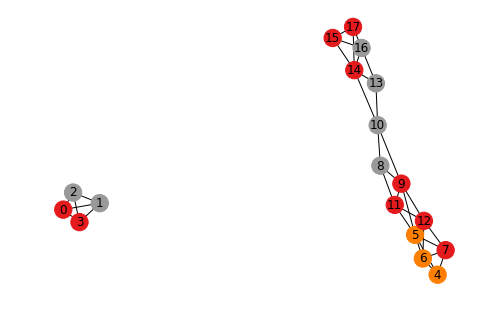

In [149]:
# test: comparing betweennees computed as a whole graph of graphs and on a per graph basis
# test ProcessGraphAsUnion for betweennes computed at the end
# RESULT: they change, even thought they seem to be similar...
print("\nTUDataset EnZYMES")
dname='TUDataset'
name='ENZYMES'
dataset = loadDataset(dname,name)
#print(dir(dataset))
dataset = [dataset[10], dataset[11] ]
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=2, debug=True)

Data(edge_index=[2, 12], x=[4, 3], y=[1])
Data(edge_index=[2, 56], x=[14, 3], y=[1])
1
Data(edge_index=[2, 34], test=[18], train=[18], val=[18], x=[34, 1], y=[34])
directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 68], test=[18], train=[18], val=[18], x=[18, 1], y=[18])
directed graph:  False
isolated nodes:  False
self loops:  False

train/val/test:
tensor([0., 0., 0., 0., 1.])
tensor([0., 0., 0., 0., 0.])
tensor([1., 1., 1., 1., 0.])

len y= 18  len(nodes)= 18  len(edges)= 34
betweenness:
node[0].betweenness= 0.0
node[1].betweenness= 0.0
node[2].betweenness= 0.0
node[3].betweenness= 0.0
node[4].betweenness= 0.0
node[5].betweenness= 0.23504273504273507
node[6].betweenness= 0.004273504273504273
node[7].betweenness= 0.004273504273504273
node[8].betweenness= 0.038461538461538464
node[9].betweenness= 0.4551282051282051
node[10].betweenness= 0.5128205128205128
node[11].betweenness= 0.03205128205128205
node[12].betweenness= 0.11538461538461538
node[13].bet

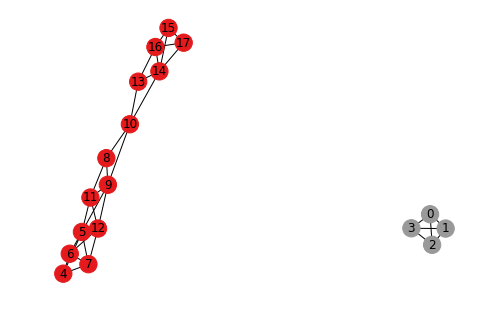

In [150]:
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=2, 
                       debug=True,separate_betweenness_comp=True,
                       node_train_test=False)

In [5]:
# test if betweenness changes as we add more graphs on the all nodes betweenness setting
dname='TUDataset'
name='ENZYMES'
dataset = loadDataset(dname,name)
#print(dir(dataset))
#dataset = [dataset[10], dataset[11],dataset[12],dataset[13],dataset[14],dataset[15],dataset[16] ]
dataset = dataset[:100]

Batch(batch=[37], edge_index=[2, 168], x=[37, 3], y=[1])
Batch(batch=[23], edge_index=[2, 102], x=[23, 3], y=[1])
1
Data(edge_index=[2, 135], test=[60], train=[60], val=[60], x=[135, 1], y=[135])
directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 270], test=[60], train=[60], val=[60], x=[60, 1], y=[60])
directed graph:  False
isolated nodes:  False
self loops:  False

train/val/test:
tensor([1., 0., 0., 1., 1.])
tensor([0., 1., 1., 0., 0.])
tensor([0., 0., 0., 0., 0.])

len y= 60  len(nodes)= 60  len(edges)= 135
betweenness:
node[0].betweenness= 0.0
node[1].betweenness= 0.004193222194391097
node[2].betweenness= 0.005938465392001333
node[3].betweenness= 0.01965109051608174
node[4].betweenness= 0.007916794225970145
node[5].betweenness= 0.013422717616171743
node[6].betweenness= 0.02867533142226306
node[7].betweenness= 0.013980499661388047
node[8].betweenness= 0.029341886764446663
node[9].betweenness= 0.004870446132865769
node[10].betweenness= 0.1151974154

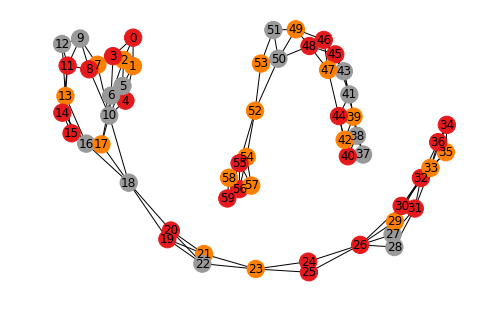

In [6]:
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=2, debug=True)

Batch(batch=[37], edge_index=[2, 168], x=[37, 3], y=[1])
Batch(batch=[23], edge_index=[2, 102], x=[23, 3], y=[1])
Batch(batch=[25], edge_index=[2, 92], x=[25, 3], y=[1])
1
Data(edge_index=[2, 181], test=[85], train=[85], val=[85], x=[181, 1], y=[181])
directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 362], test=[85], train=[85], val=[85], x=[85, 1], y=[85])
directed graph:  False
isolated nodes:  False
self loops:  False

train/val/test:
tensor([1., 0., 0., 1., 1.])
tensor([0., 0., 1., 0., 0.])
tensor([0., 1., 0., 0., 0.])

len y= 85  len(nodes)= 85  len(edges)= 181
betweenness:
node[0].betweenness= 0.0
node[1].betweenness= 0.0020581190977060145
node[2].betweenness= 0.0029147201049094323
node[3].betweenness= 0.009645156590079133
node[4].betweenness= 0.003885724303108123
node[5].betweenness= 0.006588143959056182
node[6].betweenness= 0.014074438342940934
node[7].betweenness= 0.006861914779298608
node[8].betweenness= 0.014401597318981135
node[9].betweenn

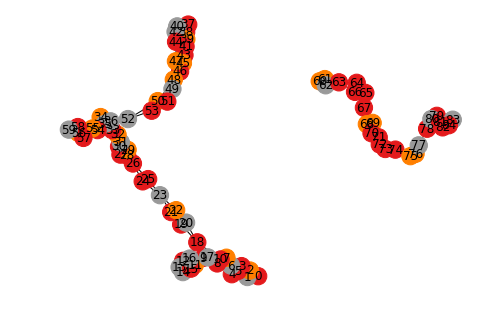

In [7]:
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=3, debug=True)

Batch(batch=[37], edge_index=[2, 168], x=[37, 3], y=[1])
Batch(batch=[23], edge_index=[2, 102], x=[23, 3], y=[1])
Batch(batch=[25], edge_index=[2, 92], x=[25, 3], y=[1])
Batch(batch=[24], edge_index=[2, 90], x=[24, 3], y=[1])
1
Data(edge_index=[2, 226], test=[109], train=[109], val=[109], x=[226, 1], y=[226])
directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 452], test=[109], train=[109], val=[109], x=[109, 1], y=[109])
directed graph:  False
isolated nodes:  False
self loops:  False

train/val/test:
tensor([1., 0., 1., 1., 1.])
tensor([0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0.])

len y= 109  len(nodes)= 109  len(edges)= 226
betweenness:
node[0].betweenness= 0.0
node[1].betweenness= 0.0012417104836627152
node[2].betweenness= 0.0017585175295455663
node[3].betweenness= 0.0058191443186251055
node[4].betweenness= 0.00234434664600812
node[5].betweenness= 0.003974778442587376
node[6].betweenness= 0.008491431648233317
node[7].betweenness= 0.00413995066

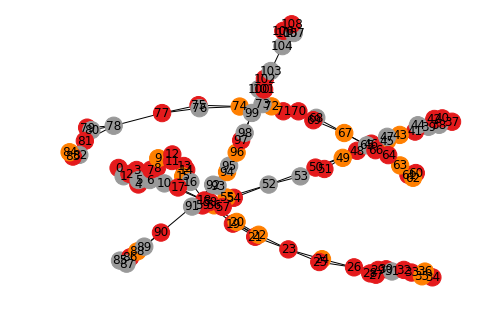

In [8]:
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=4, debug=True)
# Conclusion: as we add more graphs, the node numbering seems to be the same -> we can compare betweennes value
#            the node betweenness value decreases as we add more graphs

Batch(batch=[37], edge_index=[2, 168], x=[37, 3], y=[1])
Batch(batch=[23], edge_index=[2, 102], x=[23, 3], y=[1])
Batch(batch=[25], edge_index=[2, 92], x=[25, 3], y=[1])
Batch(batch=[24], edge_index=[2, 90], x=[24, 3], y=[1])
Batch(batch=[23], edge_index=[2, 90], x=[23, 3], y=[1])
Batch(batch=[24], edge_index=[2, 92], x=[24, 3], y=[1])
Batch(batch=[26], edge_index=[2, 118], x=[26, 3], y=[1])
Batch(batch=[88], edge_index=[2, 266], x=[88, 3], y=[1])
Batch(batch=[23], edge_index=[2, 78], x=[23, 3], y=[1])
Batch(batch=[32], edge_index=[2, 106], x=[32, 3], y=[1])
Batch(batch=[4], edge_index=[2, 12], x=[4, 3], y=[1])
Batch(batch=[14], edge_index=[2, 56], x=[14, 3], y=[1])
Batch(batch=[42], edge_index=[2, 150], x=[42, 3], y=[1])
Batch(batch=[41], edge_index=[2, 146], x=[41, 3], y=[1])
Batch(batch=[36], edge_index=[2, 128], x=[36, 3], y=[1])
Batch(batch=[55], edge_index=[2, 194], x=[55, 3], y=[1])
Batch(batch=[40], edge_index=[2, 190], x=[40, 3], y=[1])
Batch(batch=[38], edge_index=[2, 182], x

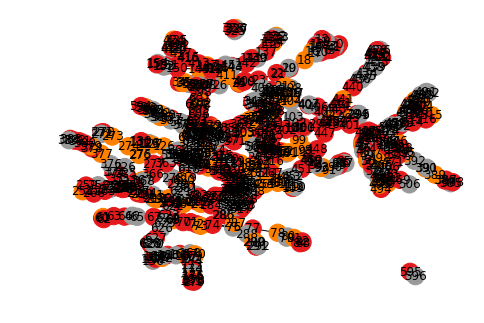

In [156]:
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=20, debug=True)

Batch(batch=[37], edge_index=[2, 168], x=[37, 3], y=[1])
Batch(batch=[23], edge_index=[2, 102], x=[23, 3], y=[1])
Batch(batch=[25], edge_index=[2, 92], x=[25, 3], y=[1])
Batch(batch=[24], edge_index=[2, 90], x=[24, 3], y=[1])
Batch(batch=[23], edge_index=[2, 90], x=[23, 3], y=[1])
Batch(batch=[24], edge_index=[2, 92], x=[24, 3], y=[1])
Batch(batch=[26], edge_index=[2, 118], x=[26, 3], y=[1])
Batch(batch=[88], edge_index=[2, 266], x=[88, 3], y=[1])
Batch(batch=[23], edge_index=[2, 78], x=[23, 3], y=[1])
Batch(batch=[32], edge_index=[2, 106], x=[32, 3], y=[1])
Batch(batch=[4], edge_index=[2, 12], x=[4, 3], y=[1])
Batch(batch=[14], edge_index=[2, 56], x=[14, 3], y=[1])
Batch(batch=[42], edge_index=[2, 150], x=[42, 3], y=[1])
Batch(batch=[41], edge_index=[2, 146], x=[41, 3], y=[1])
Batch(batch=[36], edge_index=[2, 128], x=[36, 3], y=[1])
Batch(batch=[55], edge_index=[2, 194], x=[55, 3], y=[1])
Batch(batch=[40], edge_index=[2, 190], x=[40, 3], y=[1])
Batch(batch=[38], edge_index=[2, 182], x

node[1337].betweenness= 0.0001607987615995894
node[1338].betweenness= 0.00014139817082184475
node[1339].betweenness= 0.0
node[1340].betweenness= 0.0
node[1341].betweenness= 5.8737371465134995e-05
node[1342].betweenness= 3.1064749650253765e-05
node[1343].betweenness= 3.1064749650253765e-05
node[1344].betweenness= 1.7853304396697567e-07
node[1345].betweenness= 1.7853304396697567e-07
node[1346].betweenness= 5.35599131900927e-07
node[1347].betweenness= 3.8806082462578704e-05
node[1348].betweenness= 4.26161876597092e-05
node[1349].betweenness= 9.78126537528326e-05
node[1350].betweenness= 5.0831158135734686e-05
node[1351].betweenness= 7.820307429420882e-05
node[1352].betweenness= 4.9197930848229026e-05
node[1353].betweenness= 5.301853798912231e-05
node[1354].betweenness= 3.871033974194146e-05
node[1355].betweenness= 0.00017236350207114424
node[1356].betweenness= 8.134840645115635e-05
node[1357].betweenness= 0.0001651430656694525
node[1358].betweenness= 0.0001655596427720421
node[1359].betwee

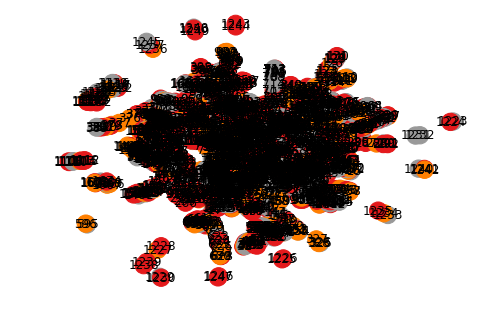

In [157]:
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=50, debug=True)

In [ ]:
processDatasetsAsUnion(dname+'_'+name, dataset, num_graphs=99, debug=True)

Batch(batch=[37], edge_index=[2, 168], x=[37, 3], y=[1])
Batch(batch=[23], edge_index=[2, 102], x=[23, 3], y=[1])
Batch(batch=[25], edge_index=[2, 92], x=[25, 3], y=[1])
Batch(batch=[24], edge_index=[2, 90], x=[24, 3], y=[1])
Batch(batch=[23], edge_index=[2, 90], x=[23, 3], y=[1])
Batch(batch=[24], edge_index=[2, 92], x=[24, 3], y=[1])
Batch(batch=[26], edge_index=[2, 118], x=[26, 3], y=[1])
Batch(batch=[88], edge_index=[2, 266], x=[88, 3], y=[1])
Batch(batch=[23], edge_index=[2, 78], x=[23, 3], y=[1])
Batch(batch=[32], edge_index=[2, 106], x=[32, 3], y=[1])
Batch(batch=[4], edge_index=[2, 12], x=[4, 3], y=[1])
Batch(batch=[14], edge_index=[2, 56], x=[14, 3], y=[1])
Batch(batch=[42], edge_index=[2, 150], x=[42, 3], y=[1])
Batch(batch=[41], edge_index=[2, 146], x=[41, 3], y=[1])
Batch(batch=[36], edge_index=[2, 128], x=[36, 3], y=[1])
Batch(batch=[55], edge_index=[2, 194], x=[55, 3], y=[1])
Batch(batch=[40], edge_index=[2, 190], x=[40, 3], y=[1])
Batch(batch=[38], edge_index=[2, 182], x

node[1340].betweenness= 0.0
node[1341].betweenness= 1.7805805233716077e-05
node[1342].betweenness= 9.417052008105159e-06
node[1343].betweenness= 9.417052008105159e-06
node[1344].betweenness= 5.41209885523285e-08
node[1345].betweenness= 5.41209885523285e-08
node[1346].betweenness= 1.623629656569855e-07
node[1347].betweenness= 1.1763780519568293e-05
node[1348].betweenness= 1.2918786087026214e-05
node[1349].betweenness= 2.965119171445447e-05
node[1350].betweenness= 1.540909439753109e-05
node[1351].betweenness= 2.370669089928623e-05
node[1352].betweenness= 1.4913993471862704e-05
node[1353].betweenness= 1.6072182626882538e-05
node[1354].betweenness= 1.1734756812962273e-05
node[1355].betweenness= 5.225073697929664e-05
node[1356].betweenness= 2.4660175374075763e-05
node[1357].betweenness= 5.006191441090386e-05
node[1358].betweenness= 5.018819671752596e-05
node[1359].betweenness= 2.247527923034267e-05
node[1360].betweenness= 4.993563210428177e-05
node[1361].betweenness= 4.993563210428176e-05
n

In [69]:
# tes ProcessGraphAsUnion, for betweenness computed at the end


ba = nx.barabasi_albert_graph(30, 5)
ba2 = nx.barabasi_albert_graph(30, 5)
g = nx.disjoint_union(ba,ba2)
createUnionGraphDataset(g,'./precomputed-pytorchg-betweenness/delete_test_nd','node')




1
Data(edge_index=[2, 500], test=[60], train=[60], val=[60], x=[60, 1], y=[60])
directed graph:  False
isolated nodes:  False
self loops:  False


In [3]:
# generate random graphs
er = nx.erdos_renyi_graph(100, 0.15)
ws = nx.watts_strogatz_graph(30, 3, 0.1)
ba = nx.barabasi_albert_graph(100, 5)
red = nx.random_lobster(100, 0.9, 0.9)
g=er


# compute its node and edge betweenness
nx_betweenness = nx.betweenness_centrality(g)
nx_edge_betweenness = nx.edge_betweenness_centrality(g)
y = [ v for k,v in nx_betweenness.items()]

# verify order of betweenness is the same as  order of edge_list
#print(nx_betweenness)
#print(y)
#-> ok!

# translate into a PyTorch Geometric dataset 
dataset = createDatasetFromNXwithTarget(g,y)

# check dimensions
print(dataset) # check edge_index[1] and y have same length


# save as a pickled object
dname = "er_100_0_15"
i=0
with open(dname+"_"+str(i)+'.pickle','wb') as f:
    pickle.dump(dataset,f)



TypeError: createDatasetFromNXwithTarget() missing 1 required positional argument: 'xlen'

In [4]:
er = nx.erdos_renyi_graph(100, 0.15)
ws = nx.watts_strogatz_graph(30, 3, 0.1)
ba = nx.barabasi_albert_graph(100, 5)
red = nx.random_lobster(100, 0.9, 0.9)

createRandomGraphDataset(er,'er_100_0_15_nb','node', undirected=False)



1
Data(edge_index=[2, 770], x=[100, 1], y=[100])
 directed graph:  True
isolated nodes:  True
self loops:  False


In [5]:
# Test MyOwnDataset2
        
er = nx.erdos_renyi_graph(5, 0.45)

# set undirected to False but later it will be transformed to undirected
createRandomGraphDataset(
    er,
    'precomputed/er_5_0_45_eb',
    'edge', 
    undirected=False)
dataset = MyOwnDataset2(
    root='', 
    name='precomputed/er_5_0_45_eb.pickle')
print(dataset.data.x)


1
Data(edge_index=[2, 5], x=[5, 1], y=[5])
 directed graph:  True
isolated nodes:  True
self loops:  False


FileNotFoundError: [Errno 2] No such file or directory: 'precomputed/er_5_0_45_eb.pickle'

### Create the random graph datasets

In [20]:
er = nx.erdos_renyi_graph(100, 0.15)
createRandomGraphDataset(er,'er_100_0_15_nb','node')
er = nx.erdos_renyi_graph(100, 0.45)
createRandomGraphDataset(er,'er_100_0_45_nb','node')
er = nx.erdos_renyi_graph(1000, 0.15)
createRandomGraphDataset(er,'er_1000_0_15_nb','node')
er = nx.erdos_renyi_graph(1000, 0.45)
createRandomGraphDataset(er,'er_1000_0_45_nb','node')


ws = nx.watts_strogatz_graph(30, 3, 0.1)
createRandomGraphDataset(ws,'ws_30_3_0_1_nb','node')
ws = nx.watts_strogatz_graph(100, 3, 0.1)
createRandomGraphDataset(ws,'ws_100_3_0_1_nb','node')
ws = nx.watts_strogatz_graph(1000, 3, 0.1)
createRandomGraphDataset(ws,'ws_1000_3_0_1_nb','node')


ws = nx.watts_strogatz_graph(1000, 10, 0.1)
createRandomGraphDataset(ws,'ws_1000_10_0_1_nb','node')


ba = nx.barabasi_albert_graph(100, 5)
createRandomGraphDataset(ba,'ba_100_5_nb','node')
ba = nx.barabasi_albert_graph(1000, 5)
createRandomGraphDataset(ba,'ba_1000_5_nb','node')



#er = nx.erdos_renyi_graph(4000, 0.15)
#createRandomGraphDataset(er,'er_4000_0_15_nb','node')
#er = nx.erdos_renyi_graph(4000, 0.35)
#createRandomGraphDataset(er,'er_4000_0_35_nb','node')
#ws = nx.watts_strogatz_graph(4000, 3, 0.1)
#createRandomGraphDataset(ws,'ws_4000_3_0_1_nb','node')
#ws = nx.watts_strogatz_graph(4000, 20, 0.1)
#createRandomGraphDataset(ws,'ws_4000_20_0_1_nb','node')
#ba = nx.barabasi_albert_graph(4000, 5)
#createRandomGraphDataset(ba,'ba_4000_5_nb','node')


1
Data(edge_index=[2, 1542], x=[100, 1], y=[100])
 directed graph:  False
isolated nodes:  False
self loops:  False
1
Data(edge_index=[2, 4432], x=[100, 1], y=[100])
 directed graph:  False
isolated nodes:  False
self loops:  False
1
Data(edge_index=[2, 149596], x=[1000, 1], y=[1000])
 directed graph:  False
isolated nodes:  False
self loops:  False
1
Data(edge_index=[2, 449110], x=[1000, 1], y=[1000])
 directed graph:  False
isolated nodes:  False
self loops:  False
1
Data(edge_index=[2, 60], x=[30, 1], y=[30])
 directed graph:  False
isolated nodes:  False
self loops:  False
1
Data(edge_index=[2, 200], x=[100, 1], y=[100])
 directed graph:  False
isolated nodes:  False
self loops:  False
1
Data(edge_index=[2, 2000], x=[1000, 1], y=[1000])
 directed graph:  False
isolated nodes:  False
self loops:  False
1
Data(edge_index=[2, 10000], x=[1000, 1], y=[1000])
 directed graph:  False
isolated nodes:  False
self loops:  False
1
Data(edge_index=[2, 950], x=[100, 1], y=[100])
 directed graph

KeyboardInterrupt: 

In [102]:
# repeat with edge betweenness
er = nx.erdos_renyi_graph(100, 0.15)
createRandomGraphDataset(er,'er_100_0_15_eb','edge', undirected=False)
er = nx.erdos_renyi_graph(100, 0.45)
createRandomGraphDataset(er,'er_100_0_45_eb','edge', undirected=False)
er = nx.erdos_renyi_graph(1000, 0.15)
createRandomGraphDataset(er,'er_1000_0_15_eb','edge', undirected=False)
er = nx.erdos_renyi_graph(1000, 0.45)
createRandomGraphDataset(er,'er_1000_0_45_eb','edge', undirected=False)


ws = nx.watts_strogatz_graph(30, 3, 0.1)
createRandomGraphDataset(ws,'ws_30_3_0_1_eb','edge', undirected=False)
ws = nx.watts_strogatz_graph(100, 3, 0.1)
createRandomGraphDataset(ws,'ws_100_3_0_1_eb','edge', undirected=False)
ws = nx.watts_strogatz_graph(1000, 3, 0.1)
createRandomGraphDataset(ws,'ws_1000_3_0_1_eb','edge', undirected=False)


ws = nx.watts_strogatz_graph(1000, 10, 0.1)
createRandomGraphDataset(ws,'ws_1000_10_0_1_eb','edge', undirected=False)


ba = nx.barabasi_albert_graph(100, 5)
createRandomGraphDataset(ba,'ba_100_5_eb','edge', undirected=False)
ba = nx.barabasi_albert_graph(1000, 5)
createRandomGraphDataset(ba,'ba_1000_5_eb','edge', undirected=False)


#er = nx.erdos_renyi_graph(4000, 0.15)
#createRandomGraphDataset(er,'er_4000_0_15_eb','edge')
#er = nx.erdos_renyi_graph(4000, 0.35)
#createRandomGraphDataset(er,'er_4000_0_35_eb','edge')
#ws = nx.watts_strogatz_graph(4000, 3, 0.1)
#createRandomGraphDataset(ws,'ws_4000_3_0_1_eb','edge')
#ws = nx.watts_strogatz_graph(4000, 20, 0.1)
#createRandomGraphDataset(ws,'ws_4000_20_0_1_eb','edge')
#ba = nx.barabasi_albert_graph(4000, 5)
#createRandomGraphDataset(ba,'ba_4000_5_eb','edge')

1
Data(edge_index=[2, 748], x=[748, 1], y=[748])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 2245], x=[2245, 1], y=[2245])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 74983], x=[74983, 1], y=[74983])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 224755], x=[224755, 1], y=[224755])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 30], x=[30, 1], y=[30])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 100], x=[100, 1], y=[100])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 1000], x=[1000, 1], y=[1000])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 5000], x=[5000, 1], y=[5000])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 475], x=[475, 1], y=[475])
 directed graph:  True
iso

## 3. Benchmark datasets

In [109]:

#KarateClub
print("\nKarateClub")
dname='KarateClub'
dataset = loadDataset(dname)
processDatasets(dname, dataset)

#ENZYMES FROM TUDataset
print("\nTUDataset EnZYMES")
dname='TUDataset'
name='ENZYMES'
dataset = loadDataset(dname,name)
processDatasets(dname+'_'+name, dataset)

#PROTEINS FROM TUDataset
print("\nTUDataset PROTEINS")
dname='TUDataset'
name='PROTEINS'
dataset = loadDataset(dname,name)
processDatasets(dname+'_'+name, dataset)

#QM7b
print("\QM7B QM7B")
dataset = loadDataset('QM7b')
processDatasets(dname,dataset)

# Planetoid Cora
print("\n Planetoid Cora")
dname='Planetoid'
name='Cora'
dataset = loadDataset(dname,name)
processDatasets(dname+'_'+name,dataset)



#---------------------------------------------------------------------


#MUTAG
#print("\n MUTAG")
#dname='Entities'
#name='MUTAG'
#dataset = loadDataset(dname,name)
#processDatasets(dname+'_'+name,dataset)



#PPI
#print("\PPI PPI")
#dname='PPI'
#dataset = loadDataset(dname)
#processDatasets(dname,dataset)



        
        



KarateClub
Batch(batch=[34], edge_index=[2, 156], x=[34, 34], y=[34])
1
1
Data(edge_index=[2, 78], x=[78, 1], y=[78])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 156], x=[34, 1], y=[34])
 directed graph:  False
isolated nodes:  False
self loops:  False

TUDataset EnZYMES
Extracting data/TUDataset/ENZYMES.zip
Processing...
Done!
Batch(batch=[37], edge_index=[2, 168], x=[37, 3], y=[1])
1
1
Data(edge_index=[2, 84], x=[84, 1], y=[84])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 168], x=[37, 1], y=[37])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[23], edge_index=[2, 102], x=[23, 3], y=[1])
2
1
Data(edge_index=[2, 51], x=[51, 1], y=[51])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 102], x=[23, 1], y=[23])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[25], edge_index=[2, 92], x=[25, 3], y=[1])
3
1
Dat

1
Data(edge_index=[2, 86], x=[24, 1], y=[24])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[24], edge_index=[2, 100], x=[24, 3], y=[1])
40
1
Data(edge_index=[2, 50], x=[50, 1], y=[50])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 100], x=[24, 1], y=[24])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[47], edge_index=[2, 190], x=[47, 3], y=[1])
41
1
Data(edge_index=[2, 95], x=[95, 1], y=[95])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 190], x=[47, 1], y=[47])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[45], edge_index=[2, 194], x=[45, 3], y=[1])
42
1
Data(edge_index=[2, 97], x=[97, 1], y=[97])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 194], x=[45, 1], y=[45])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[45], edge_index=[2, 190], 

 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 176], x=[38, 1], y=[38])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[40], edge_index=[2, 140], x=[40, 3], y=[1])
72
1
Data(edge_index=[2, 70], x=[70, 1], y=[70])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 140], x=[40, 1], y=[40])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[40], edge_index=[2, 174], x=[40, 3], y=[1])
73
1
Data(edge_index=[2, 87], x=[87, 1], y=[87])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 174], x=[40, 1], y=[40])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[42], edge_index=[2, 188], x=[42, 3], y=[1])
74
1
Data(edge_index=[2, 94], x=[94, 1], y=[94])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 188], x=[42, 1], y=[42])
 directed graph:  False
isolated nodes: 

1
Data(edge_index=[2, 29], x=[29, 1], y=[29])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 58], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[26], edge_index=[2, 98], x=[26, 3], y=[1])
111
1
Data(edge_index=[2, 49], x=[49, 1], y=[49])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 98], x=[26, 1], y=[26])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[51], edge_index=[2, 190], x=[51, 3], y=[1])
112
1
Data(edge_index=[2, 95], x=[95, 1], y=[95])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 190], x=[51, 1], y=[51])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[52], edge_index=[2, 196], x=[52, 3], y=[1])
113
1
Data(edge_index=[2, 98], x=[98, 1], y=[98])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 196], x=[52, 1], y=

1
Data(edge_index=[2, 82], x=[29, 1], y=[29])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[22], edge_index=[2, 80], x=[22, 3], y=[1])
151
1
Data(edge_index=[2, 40], x=[40, 1], y=[40])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 80], x=[22, 1], y=[22])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[11], edge_index=[2, 44], x=[11, 3], y=[1])
152
1
Data(edge_index=[2, 22], x=[22, 1], y=[22])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 44], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[8], edge_index=[2, 32], x=[8, 3], y=[1])
153
1
Data(edge_index=[2, 16], x=[16, 1], y=[16])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 32], x=[8, 1], y=[8])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[13], edge_index=[2, 44], x=[13, 3

1
Data(edge_index=[2, 96], x=[96, 1], y=[96])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 192], x=[48, 1], y=[48])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[31], edge_index=[2, 132], x=[31, 3], y=[1])
192
1
Data(edge_index=[2, 66], x=[66, 1], y=[66])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 132], x=[31, 1], y=[31])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[30], edge_index=[2, 120], x=[30, 3], y=[1])
193
1
Data(edge_index=[2, 60], x=[60, 1], y=[60])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 120], x=[30, 1], y=[30])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[46], edge_index=[2, 200], x=[46, 3], y=[1])
194
1
Data(edge_index=[2, 100], x=[100, 1], y=[100])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 200], x=[46, 

 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[54], edge_index=[2, 210], x=[54, 3], y=[1])
224
1
Data(edge_index=[2, 105], x=[105, 1], y=[105])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 210], x=[54, 1], y=[54])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[18], edge_index=[2, 70], x=[18, 3], y=[1])
225
1
Data(edge_index=[2, 35], x=[35, 1], y=[35])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 70], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[36], edge_index=[2, 148], x=[36, 3], y=[1])
226
1
Data(edge_index=[2, 74], x=[74, 1], y=[74])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 148], x=[36, 1], y=[36])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[37], edge_index=[2, 162], x=[37, 3], y=[1])
227
1
Data(edge_index=[2

self loops:  False
Batch(batch=[34], edge_index=[2, 146], x=[34, 3], y=[1])
269
1
Data(edge_index=[2, 73], x=[73, 1], y=[73])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 146], x=[34, 1], y=[34])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[32], edge_index=[2, 120], x=[32, 3], y=[1])
270
1
Data(edge_index=[2, 60], x=[60, 1], y=[60])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 120], x=[32, 1], y=[32])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[32], edge_index=[2, 140], x=[32, 3], y=[1])
271
1
Data(edge_index=[2, 70], x=[70, 1], y=[70])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 140], x=[32, 1], y=[32])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[44], edge_index=[2, 156], x=[44, 3], y=[1])
272
1
Data(edge_index=[2, 78], x=[78, 1], y=[78])
 directed graph:  True

 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 186], x=[46, 1], y=[46])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[55], edge_index=[2, 196], x=[55, 3], y=[1])
306
1
Data(edge_index=[2, 98], x=[98, 1], y=[98])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 196], x=[55, 1], y=[55])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[50], edge_index=[2, 184], x=[50, 3], y=[1])
307
1
Data(edge_index=[2, 92], x=[92, 1], y=[92])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 184], x=[50, 1], y=[50])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[42], edge_index=[2, 164], x=[42, 3], y=[1])
308
1
Data(edge_index=[2, 82], x=[82, 1], y=[82])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 164], x=[42, 1], y=[42])
 directed graph:  False
isolated node

343
1
Data(edge_index=[2, 45], x=[45, 1], y=[45])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 90], x=[24, 1], y=[24])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[23], edge_index=[2, 78], x=[23, 3], y=[1])
344
1
Data(edge_index=[2, 39], x=[39, 1], y=[39])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 78], x=[23, 1], y=[23])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[27], edge_index=[2, 116], x=[27, 3], y=[1])
345
1
Data(edge_index=[2, 58], x=[58, 1], y=[58])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 116], x=[27, 1], y=[27])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[39], edge_index=[2, 134], x=[39, 3], y=[1])
346
1
Data(edge_index=[2, 67], x=[67, 1], y=[67])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 134], x=[39, 1]

Batch(batch=[36], edge_index=[2, 140], x=[36, 3], y=[1])
377
1
Data(edge_index=[2, 70], x=[70, 1], y=[70])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 140], x=[36, 1], y=[36])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[30], edge_index=[2, 102], x=[30, 3], y=[1])
378
1
Data(edge_index=[2, 51], x=[51, 1], y=[51])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 102], x=[30, 1], y=[30])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[30], edge_index=[2, 104], x=[30, 3], y=[1])
379
1
Data(edge_index=[2, 52], x=[52, 1], y=[52])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 104], x=[30, 1], y=[30])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[36], edge_index=[2, 122], x=[36, 3], y=[1])
380
1
Data(edge_index=[2, 61], x=[61, 1], y=[61])
 directed graph:  True
isolated nodes:  T

1
Data(edge_index=[2, 132], x=[33, 1], y=[33])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[32], edge_index=[2, 120], x=[32, 3], y=[1])
409
1
Data(edge_index=[2, 60], x=[60, 1], y=[60])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 120], x=[32, 1], y=[32])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[28], edge_index=[2, 124], x=[28, 3], y=[1])
410
1
Data(edge_index=[2, 62], x=[62, 1], y=[62])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 124], x=[28, 1], y=[28])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[37], edge_index=[2, 138], x=[37, 3], y=[1])
411
1
Data(edge_index=[2, 69], x=[69, 1], y=[69])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 138], x=[37, 1], y=[37])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[36], edge_index=[2, 13

 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 198], x=[48, 1], y=[48])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[46], edge_index=[2, 198], x=[46, 3], y=[1])
439
1
Data(edge_index=[2, 99], x=[99, 1], y=[99])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 198], x=[46, 1], y=[46])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[26], edge_index=[2, 100], x=[26, 3], y=[1])
440
1
Data(edge_index=[2, 50], x=[50, 1], y=[50])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 100], x=[26, 1], y=[26])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[25], edge_index=[2, 112], x=[25, 3], y=[1])
441
1
Data(edge_index=[2, 56], x=[56, 1], y=[56])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 112], x=[25, 1], y=[25])
 directed graph:  False
isolated node

1
Data(edge_index=[2, 160], x=[60, 1], y=[60])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[39], edge_index=[2, 144], x=[39, 3], y=[1])
485
1
Data(edge_index=[2, 72], x=[72, 1], y=[72])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 144], x=[39, 1], y=[39])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[26], edge_index=[2, 102], x=[26, 3], y=[1])
486
1
Data(edge_index=[2, 51], x=[51, 1], y=[51])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 102], x=[26, 1], y=[26])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[15], edge_index=[2, 54], x=[15, 3], y=[1])
487
1
Data(edge_index=[2, 27], x=[27, 1], y=[27])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 54], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[25], edge_index=[2, 84],

 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 164], x=[37, 1], y=[37])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[48], edge_index=[2, 222], x=[48, 3], y=[1])
523
1
Data(edge_index=[2, 111], x=[111, 1], y=[111])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 222], x=[48, 1], y=[48])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[41], edge_index=[2, 148], x=[41, 3], y=[1])
524
1
Data(edge_index=[2, 74], x=[74, 1], y=[74])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 148], x=[41, 1], y=[41])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[29], edge_index=[2, 132], x=[29, 3], y=[1])
525
1
Data(edge_index=[2, 66], x=[66, 1], y=[66])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 132], x=[29, 1], y=[29])
 directed graph:  False
isolated n

1
Data(edge_index=[2, 48], x=[48, 1], y=[48])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 96], x=[26, 1], y=[26])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[52], edge_index=[2, 198], x=[52, 3], y=[1])
557
1
Data(edge_index=[2, 99], x=[99, 1], y=[99])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 198], x=[52, 1], y=[52])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[50], edge_index=[2, 186], x=[50, 3], y=[1])
558
1
Data(edge_index=[2, 93], x=[93, 1], y=[93])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 186], x=[50, 1], y=[50])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[38], edge_index=[2, 134], x=[38, 3], y=[1])
559
1
Data(edge_index=[2, 67], x=[67, 1], y=[67])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 134], x=[38, 1], 

 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[44], edge_index=[2, 180], x=[44, 3], y=[1])
595
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 180], x=[44, 1], y=[44])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[45], edge_index=[2, 182], x=[45, 3], y=[1])
596
1
Data(edge_index=[2, 91], x=[91, 1], y=[91])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 182], x=[45, 1], y=[45])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[52], edge_index=[2, 232], x=[52, 3], y=[1])
597
1
Data(edge_index=[2, 116], x=[116, 1], y=[116])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 232], x=[52, 1], y=[52])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[55], edge_index=[2, 200], x=[55, 3], y=[1])
598
1
Data(edge_index=

TypeError: __init__() missing 1 required positional argument: 'root'

In [110]:

#PROTEINS FROM TUDataset
print("\nTUDataset PROTEINS")
dname='TUDataset'
name='PROTEINS'
dataset = loadDataset(dname,name)
processDatasets(dname+'_'+name, dataset)

#QM7b
print("\QM7B QM7B")
dataset = loadDataset('QM7b')
processDatasets(dname,dataset)

# Planetoid Cora
print("\n Planetoid Cora")
dname='Planetoid'
name='Cora'
dataset = loadDataset(dname,name)
processDatasets(dname+'_'+name,dataset)






TUDataset PROTEINS
Extracting data/TUDataset/PROTEINS.zip
Processing...
Done!
Batch(batch=[42], edge_index=[2, 162], x=[42, 3], y=[1])
1
1
Data(edge_index=[2, 81], x=[81, 1], y=[81])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 162], x=[42, 1], y=[42])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[27], edge_index=[2, 92], x=[27, 3], y=[1])
2
1
Data(edge_index=[2, 46], x=[46, 1], y=[46])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 92], x=[27, 1], y=[27])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[10], edge_index=[2, 34], x=[10, 3], y=[1])
3
1
Data(edge_index=[2, 17], x=[17, 1], y=[17])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 34], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[24], edge_index=[2, 92], x=[24, 3], y=[1])
4
1
Data(edge_index=[2,

1
Data(edge_index=[2, 74], x=[74, 1], y=[74])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 148], x=[33, 1], y=[33])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[89], edge_index=[2, 286], x=[89, 3], y=[1])
40
1
Data(edge_index=[2, 143], x=[143, 1], y=[143])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 286], x=[89, 1], y=[89])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[50], edge_index=[2, 174], x=[50, 3], y=[1])
41
1
Data(edge_index=[2, 87], x=[87, 1], y=[87])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 174], x=[50, 1], y=[50])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[15], edge_index=[2, 50], x=[15, 3], y=[1])
42
1
Data(edge_index=[2, 25], x=[25, 1], y=[25])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 50], x=[15, 1], y

1
Data(edge_index=[2, 150], x=[150, 1], y=[150])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 300], x=[72, 1], y=[72])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[76], edge_index=[2, 240], x=[76, 3], y=[1])
75
1
Data(edge_index=[2, 120], x=[120, 1], y=[120])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 240], x=[76, 1], y=[76])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[6], edge_index=[2, 22], x=[6, 3], y=[1])
76
1
Data(edge_index=[2, 11], x=[11, 1], y=[11])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 22], x=[6, 1], y=[6])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[620], edge_index=[2, 2098], x=[620, 3], y=[1])
77
1
Data(edge_index=[2, 1049], x=[1049, 1], y=[1049])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 2098], x=[

isolated nodes:  False
self loops:  False
Batch(batch=[11], edge_index=[2, 42], x=[11, 3], y=[1])
106
1
Data(edge_index=[2, 21], x=[21, 1], y=[21])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 42], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[244], edge_index=[2, 782], x=[244, 3], y=[1])
107
1
Data(edge_index=[2, 391], x=[391, 1], y=[391])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 782], x=[244, 1], y=[244])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[80], edge_index=[2, 328], x=[80, 3], y=[1])
108
1
Data(edge_index=[2, 164], x=[164, 1], y=[164])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 328], x=[80, 1], y=[80])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[22], edge_index=[2, 100], x=[22, 3], y=[1])
109
1
Data(edge_index=[2, 50], x=[50, 1],

1
Data(edge_index=[2, 216], x=[216, 1], y=[216])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 432], x=[122, 1], y=[122])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[28], edge_index=[2, 98], x=[28, 3], y=[1])
141
1
Data(edge_index=[2, 49], x=[49, 1], y=[49])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 98], x=[28, 1], y=[28])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[51], edge_index=[2, 190], x=[51, 3], y=[1])
142
1
Data(edge_index=[2, 95], x=[95, 1], y=[95])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 190], x=[51, 1], y=[51])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[99], edge_index=[2, 312], x=[99, 3], y=[1])
143
1
Data(edge_index=[2, 156], x=[156, 1], y=[156])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 312], x=[9

172
1
Data(edge_index=[2, 153], x=[153, 1], y=[153])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 306], x=[75, 1], y=[75])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[21], edge_index=[2, 86], x=[21, 3], y=[1])
173
1
Data(edge_index=[2, 43], x=[43, 1], y=[43])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 86], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[27], edge_index=[2, 88], x=[27, 3], y=[1])
174
1
Data(edge_index=[2, 44], x=[44, 1], y=[44])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 88], x=[27, 1], y=[27])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[80], edge_index=[2, 252], x=[80, 3], y=[1])
175
1
Data(edge_index=[2, 126], x=[126, 1], y=[126])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 252], x=[8

1
Data(edge_index=[2, 87], x=[87, 1], y=[87])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 174], x=[42, 1], y=[42])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[66], edge_index=[2, 270], x=[66, 3], y=[1])
209
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 270], x=[66, 1], y=[66])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[88], edge_index=[2, 330], x=[88, 3], y=[1])
210
1
Data(edge_index=[2, 165], x=[165, 1], y=[165])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 330], x=[88, 1], y=[88])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[60], edge_index=[2, 242], x=[60, 3], y=[1])
211
1
Data(edge_index=[2, 121], x=[121, 1], y=[121])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 242], x

1
Data(edge_index=[2, 164], x=[164, 1], y=[164])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 328], x=[105, 1], y=[105])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[29], edge_index=[2, 120], x=[29, 3], y=[1])
241
1
Data(edge_index=[2, 60], x=[60, 1], y=[60])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 120], x=[29, 1], y=[29])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[30], edge_index=[2, 132], x=[30, 3], y=[1])
242
1
Data(edge_index=[2, 66], x=[66, 1], y=[66])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 132], x=[30, 1], y=[30])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[38], edge_index=[2, 164], x=[38, 3], y=[1])
243
1
Data(edge_index=[2, 82], x=[82, 1], y=[82])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 164], x=[38

1
Data(edge_index=[2, 178], x=[178, 1], y=[178])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 356], x=[105, 1], y=[105])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[33], edge_index=[2, 136], x=[33, 3], y=[1])
275
1
Data(edge_index=[2, 68], x=[68, 1], y=[68])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 136], x=[33, 1], y=[33])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[226], edge_index=[2, 632], x=[226, 3], y=[1])
276
1
Data(edge_index=[2, 316], x=[316, 1], y=[316])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 632], x=[226, 1], y=[226])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[17], edge_index=[2, 64], x=[17, 3], y=[1])
277
1
Data(edge_index=[2, 32], x=[32, 1], y=[32])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 64], 

1
Data(edge_index=[2, 236], x=[79, 1], y=[79])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[74], edge_index=[2, 250], x=[74, 3], y=[1])
306
1
Data(edge_index=[2, 125], x=[125, 1], y=[125])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 250], x=[74, 1], y=[74])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[88], edge_index=[2, 284], x=[88, 3], y=[1])
307
1
Data(edge_index=[2, 142], x=[142, 1], y=[142])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 284], x=[88, 1], y=[88])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[34], edge_index=[2, 132], x=[34, 3], y=[1])
308
1
Data(edge_index=[2, 66], x=[66, 1], y=[66])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 132], x=[34, 1], y=[34])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[328], edge_index

 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[32], edge_index=[2, 138], x=[32, 3], y=[1])
339
1
Data(edge_index=[2, 69], x=[69, 1], y=[69])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 138], x=[32, 1], y=[32])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[70], edge_index=[2, 282], x=[70, 3], y=[1])
340
1
Data(edge_index=[2, 141], x=[141, 1], y=[141])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 282], x=[70, 1], y=[70])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[88], edge_index=[2, 420], x=[88, 3], y=[1])
341
1
Data(edge_index=[2, 210], x=[210, 1], y=[210])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 420], x=[88, 1], y=[88])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[16], edge_index=[2, 72], x=[16, 3], y=[1])
342
1
Data(edge_inde

1
Data(edge_index=[2, 214], x=[214, 1], y=[214])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 428], x=[125, 1], y=[125])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[27], edge_index=[2, 120], x=[27, 3], y=[1])
376
1
Data(edge_index=[2, 60], x=[60, 1], y=[60])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 120], x=[27, 1], y=[27])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[34], edge_index=[2, 160], x=[34, 3], y=[1])
377
1
Data(edge_index=[2, 80], x=[80, 1], y=[80])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 160], x=[34, 1], y=[34])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[82], edge_index=[2, 342], x=[82, 3], y=[1])
378
1
Data(edge_index=[2, 171], x=[171, 1], y=[171])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 342], x=

1
Data(edge_index=[2, 214], x=[214, 1], y=[214])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 428], x=[122, 1], y=[122])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[42], edge_index=[2, 168], x=[42, 3], y=[1])
406
1
Data(edge_index=[2, 84], x=[84, 1], y=[84])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 168], x=[42, 1], y=[42])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[16], edge_index=[2, 52], x=[16, 3], y=[1])
407
1
Data(edge_index=[2, 26], x=[26, 1], y=[26])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 52], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[37], edge_index=[2, 134], x=[37, 3], y=[1])
408
1
Data(edge_index=[2, 67], x=[67, 1], y=[67])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 134], x=[37, 

1
Data(edge_index=[2, 360], x=[85, 1], y=[85])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[14], edge_index=[2, 52], x=[14, 3], y=[1])
440
1
Data(edge_index=[2, 26], x=[26, 1], y=[26])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 52], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[48], edge_index=[2, 186], x=[48, 3], y=[1])
441
1
Data(edge_index=[2, 93], x=[93, 1], y=[93])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 186], x=[48, 1], y=[48])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[46], edge_index=[2, 182], x=[46, 3], y=[1])
442
1
Data(edge_index=[2, 91], x=[91, 1], y=[91])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 182], x=[46, 1], y=[46])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[12], edge_index=[2, 40],

1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 340], x=[86, 1], y=[86])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[37], edge_index=[2, 132], x=[37, 3], y=[1])
472
1
Data(edge_index=[2, 66], x=[66, 1], y=[66])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 132], x=[37, 1], y=[37])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[12], edge_index=[2, 46], x=[12, 3], y=[1])
473
1
Data(edge_index=[2, 23], x=[23, 1], y=[23])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 46], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[20], edge_index=[2, 70], x=[20, 3], y=[1])
474
1
Data(edge_index=[2, 35], x=[35, 1], y=[35])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 70], x=[20, 1], 

1
Data(edge_index=[2, 310], x=[80, 1], y=[80])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[30], edge_index=[2, 100], x=[30, 3], y=[1])
504
1
Data(edge_index=[2, 50], x=[50, 1], y=[50])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 100], x=[30, 1], y=[30])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[52], edge_index=[2, 172], x=[52, 3], y=[1])
505
1
Data(edge_index=[2, 86], x=[86, 1], y=[86])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 172], x=[52, 1], y=[52])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[9], edge_index=[2, 32], x=[9, 3], y=[1])
506
1
Data(edge_index=[2, 16], x=[16, 1], y=[16])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 32], x=[9, 1], y=[9])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[22], edge_index=[2, 78], x=[

544
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 238], x=[58, 1], y=[58])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[28], edge_index=[2, 120], x=[28, 3], y=[1])
545
1
Data(edge_index=[2, 60], x=[60, 1], y=[60])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 120], x=[28, 1], y=[28])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[14], edge_index=[2, 48], x=[14, 3], y=[1])
546
1
Data(edge_index=[2, 24], x=[24, 1], y=[24])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 48], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[39], edge_index=[2, 142], x=[39, 3], y=[1])
547
1
Data(edge_index=[2, 71], x=[71, 1], y=[71])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 142], x=[39

 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[7], edge_index=[2, 26], x=[7, 3], y=[1])
576
1
Data(edge_index=[2, 13], x=[13, 1], y=[13])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 26], x=[7, 1], y=[7])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[24], edge_index=[2, 84], x=[24, 3], y=[1])
577
1
Data(edge_index=[2, 42], x=[42, 1], y=[42])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 84], x=[24, 1], y=[24])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[91], edge_index=[2, 304], x=[91, 3], y=[1])
578
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 304], x=[91, 1], y=[91])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[30], edge_index=[2, 110], x=[30, 3], y=[1])
579
1
Data(edge_index=[2, 55],

Batch(batch=[7], edge_index=[2, 24], x=[7, 3], y=[1])
607
1
Data(edge_index=[2, 12], x=[12, 1], y=[12])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 24], x=[7, 1], y=[7])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[23], edge_index=[2, 80], x=[23, 3], y=[1])
608
1
Data(edge_index=[2, 40], x=[40, 1], y=[40])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 80], x=[23, 1], y=[23])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[58], edge_index=[2, 232], x=[58, 3], y=[1])
609
1
Data(edge_index=[2, 116], x=[116, 1], y=[116])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 232], x=[58, 1], y=[58])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[133], edge_index=[2, 460], x=[133, 3], y=[1])
610
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  T

1
Data(edge_index=[2, 112], x=[112, 1], y=[112])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 224], x=[59, 1], y=[59])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[18], edge_index=[2, 68], x=[18, 3], y=[1])
642
1
Data(edge_index=[2, 34], x=[34, 1], y=[34])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 68], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[26], edge_index=[2, 102], x=[26, 3], y=[1])
643
1
Data(edge_index=[2, 51], x=[51, 1], y=[51])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 102], x=[26, 1], y=[26])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[102], edge_index=[2, 420], x=[102, 3], y=[1])
644
1
Data(edge_index=[2, 210], x=[210, 1], y=[210])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 420], x=[1

 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 44], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[6], edge_index=[2, 22], x=[6, 3], y=[1])
683
1
Data(edge_index=[2, 11], x=[11, 1], y=[11])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 22], x=[6, 1], y=[6])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[26], edge_index=[2, 84], x=[26, 3], y=[1])
684
1
Data(edge_index=[2, 42], x=[42, 1], y=[42])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 84], x=[26, 1], y=[26])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[30], edge_index=[2, 120], x=[30, 3], y=[1])
685
1
Data(edge_index=[2, 60], x=[60, 1], y=[60])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 120], x=[30, 1], y=[30])
 directed graph:  False
isolated nodes:  False

713
1
Data(edge_index=[2, 42], x=[42, 1], y=[42])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 84], x=[22, 1], y=[22])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[12], edge_index=[2, 38], x=[12, 3], y=[1])
714
1
Data(edge_index=[2, 19], x=[19, 1], y=[19])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 38], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[47], edge_index=[2, 188], x=[47, 3], y=[1])
715
1
Data(edge_index=[2, 94], x=[94, 1], y=[94])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 188], x=[47, 1], y=[47])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[11], edge_index=[2, 40], x=[11, 3], y=[1])
716
1
Data(edge_index=[2, 20], x=[20, 1], y=[20])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 40], x=[11, 1], 

1
Data(edge_index=[2, 54], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[64], edge_index=[2, 258], x=[64, 3], y=[1])
758
1
Data(edge_index=[2, 129], x=[129, 1], y=[129])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 258], x=[64, 1], y=[64])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[140], edge_index=[2, 366], x=[140, 3], y=[1])
759
1
Data(edge_index=[2, 183], x=[183, 1], y=[183])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 366], x=[140, 1], y=[140])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[11], edge_index=[2, 40], x=[11, 3], y=[1])
760
1
Data(edge_index=[2, 20], x=[20, 1], y=[20])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 40], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[150], edge_inde

 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 84], x=[22, 1], y=[22])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[23], edge_index=[2, 82], x=[23, 3], y=[1])
796
1
Data(edge_index=[2, 41], x=[41, 1], y=[41])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 82], x=[23, 1], y=[23])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[17], edge_index=[2, 60], x=[17, 3], y=[1])
797
1
Data(edge_index=[2, 30], x=[30, 1], y=[30])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 60], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[8], edge_index=[2, 32], x=[8, 3], y=[1])
798
1
Data(edge_index=[2, 16], x=[16, 1], y=[16])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 32], x=[8, 1], y=[8])
 directed graph:  False
isolated nodes:  False
s

1
Data(edge_index=[2, 121], x=[121, 1], y=[121])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 242], x=[70, 1], y=[70])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[20], edge_index=[2, 70], x=[20, 3], y=[1])
834
1
Data(edge_index=[2, 35], x=[35, 1], y=[35])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 70], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[5], edge_index=[2, 18], x=[5, 3], y=[1])
835
1
Data(edge_index=[2, 9], x=[9, 1], y=[9])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 18], x=[5, 1], y=[5])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[78], edge_index=[2, 264], x=[78, 3], y=[1])
836
1
Data(edge_index=[2, 132], x=[132, 1], y=[132])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 264], x=[78, 1], y=[7

1
Data(edge_index=[2, 320], x=[93, 1], y=[93])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[32], edge_index=[2, 120], x=[32, 3], y=[1])
865
1
Data(edge_index=[2, 60], x=[60, 1], y=[60])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 120], x=[32, 1], y=[32])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[11], edge_index=[2, 38], x=[11, 3], y=[1])
866
1
Data(edge_index=[2, 19], x=[19, 1], y=[19])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 38], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[8], edge_index=[2, 30], x=[8, 3], y=[1])
867
1
Data(edge_index=[2, 15], x=[15, 1], y=[15])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 30], x=[8, 1], y=[8])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[6], edge_index=[2, 22], x=[6, 

Batch(batch=[62], edge_index=[2, 178], x=[62, 3], y=[1])
910
1
Data(edge_index=[2, 89], x=[89, 1], y=[89])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 178], x=[62, 1], y=[62])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[8], edge_index=[2, 28], x=[8, 3], y=[1])
911
1
Data(edge_index=[2, 14], x=[14, 1], y=[14])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 28], x=[8, 1], y=[8])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[40], edge_index=[2, 144], x=[40, 3], y=[1])
912
1
Data(edge_index=[2, 72], x=[72, 1], y=[72])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 144], x=[40, 1], y=[40])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[12], edge_index=[2, 40], x=[12, 3], y=[1])
913
1
Data(edge_index=[2, 20], x=[20, 1], y=[20])
 directed graph:  True
isolated nodes:  True
sel

 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[72], edge_index=[2, 252], x=[72, 3], y=[1])
947
1
Data(edge_index=[2, 126], x=[126, 1], y=[126])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 252], x=[72, 1], y=[72])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[30], edge_index=[2, 106], x=[30, 3], y=[1])
948
1
Data(edge_index=[2, 53], x=[53, 1], y=[53])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 106], x=[30, 1], y=[30])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[14], edge_index=[2, 52], x=[14, 3], y=[1])
949
1
Data(edge_index=[2, 26], x=[26, 1], y=[26])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 52], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[4], edge_index=[2, 12], x=[4, 3], y=[1])
950
1
Data(edge_index=[2, 6

1
Data(edge_index=[2, 118], x=[36, 1], y=[36])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[20], edge_index=[2, 68], x=[20, 3], y=[1])
990
1
Data(edge_index=[2, 34], x=[34, 1], y=[34])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 68], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[47], edge_index=[2, 188], x=[47, 3], y=[1])
991
1
Data(edge_index=[2, 94], x=[94, 1], y=[94])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 188], x=[47, 1], y=[47])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[23], edge_index=[2, 94], x=[23, 3], y=[1])
992
1
Data(edge_index=[2, 47], x=[47, 1], y=[47])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 94], x=[23, 1], y=[23])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[11], edge_index=[2, 40], x

1
Data(edge_index=[2, 44], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[5], edge_index=[2, 18], x=[5, 3], y=[1])
1023
1
Data(edge_index=[2, 9], x=[9, 1], y=[9])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 18], x=[5, 1], y=[5])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[16], edge_index=[2, 52], x=[16, 3], y=[1])
1024
1
Data(edge_index=[2, 26], x=[26, 1], y=[26])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 52], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[90], edge_index=[2, 278], x=[90, 3], y=[1])
1025
1
Data(edge_index=[2, 139], x=[139, 1], y=[139])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 278], x=[90, 1], y=[90])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[9], edge_index=[2, 34], x=[9

1
Data(edge_index=[2, 86], x=[86, 1], y=[86])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 172], x=[64, 1], y=[64])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[14], edge_index=[2, 52], x=[14, 3], y=[1])
1067
1
Data(edge_index=[2, 26], x=[26, 1], y=[26])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 52], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[9], edge_index=[2, 32], x=[9, 3], y=[1])
1068
1
Data(edge_index=[2, 16], x=[16, 1], y=[16])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 32], x=[9, 1], y=[9])
 directed graph:  False
isolated nodes:  False
self loops:  False
Batch(batch=[11], edge_index=[2, 40], x=[11, 3], y=[1])
1069
1
Data(edge_index=[2, 20], x=[20, 1], y=[20])
 directed graph:  True
isolated nodes:  True
self loops:  False
1
Data(edge_index=[2, 40], x=[11, 1], y=[11]

Batch(batch=[5], edge_attr=[25], edge_index=[2, 25], y=[1, 14])
1
1
Data(edge_index=[2, 14], x=[14, 1], y=[14])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 28], x=[5, 1], y=[5])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[8], edge_attr=[64], edge_index=[2, 64], y=[1, 14])
2
1
Data(edge_index=[2, 35], x=[35, 1], y=[35])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 70], x=[8, 1], y=[8])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[6], edge_attr=[36], edge_index=[2, 36], y=[1, 14])
3
1
Data(edge_index=[2, 20], x=[20, 1], y=[20])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 40], x=[6, 1], y=[6])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[4], edge_attr=[16], edge_index=[2, 16], y=[1, 14])
4
1
Data(edge_index=[2, 9], x=[9, 1], y=[9])
 directed graph:  True
isolated nodes: 

isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
59
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
60
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
61
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
62
1
Data(edg

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
111
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
112
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[8], edge_attr=[64], edge_index=[2, 64], y=[1, 14])
113
1
Data(edge_index=[2, 35], x=[35, 1], y=[35])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 70], x=[8, 1], y=[8])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14]

162
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
163
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
164
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
165
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Dat

1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
191
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
192
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
193
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(bat

1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
220
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
221
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
222
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
D

1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
258
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
259
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
260
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Bat

1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
304
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
305
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
306
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Bat

351
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
352
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
353
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
354
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1


 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
398
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
399
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
400
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directe

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
443
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
444
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
445
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directe

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
485
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
486
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
487
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
528
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
529
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
530
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directe

1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
571
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
572
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
573
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Bat

619
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
620
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
621
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
622
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(e

1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
669
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
670
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
671
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Bat

1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
717
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
718
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
719
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
763
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
764
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
765
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 dire

Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
811
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
812
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
813
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(e

1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
854
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
855
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
856
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(

1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
904
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
905
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
906
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(ed

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
958
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
959
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
960
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
1008
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
1009
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1010
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directe

1055
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1056
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1057
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1058
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1102
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1103
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
1104
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 dire

Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
1157
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
1158
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
1159
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
1160
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])


1195
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[21], edge_attr=[441], edge_index=[2, 441], y=[1, 14])
1196
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[21], edge_attr=[441], edge_index=[2, 441], y=[1, 14])
1197
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[21], edge_attr=[441], edge_index=[2, 441], y=[1, 14])
1198
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  

1223
1
Data(edge_index=[2, 275], x=[275, 1], y=[275])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 550], x=[23, 1], y=[23])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[23], edge_attr=[529], edge_index=[2, 529], y=[1, 14])
1224
1
Data(edge_index=[2, 275], x=[275, 1], y=[275])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 550], x=[23, 1], y=[23])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[23], edge_attr=[529], edge_index=[2, 529], y=[1, 14])
1225
1
Data(edge_index=[2, 275], x=[275, 1], y=[275])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 550], x=[23, 1], y=[23])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[23], edge_attr=[529], edge_index=[2, 529], y=[1, 14])
1226
1
Data(edge_index=[2, 275], x=[275, 1], y=[275])
 directed graph:  True
isolated nodes:  True
self loops:  

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1259
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1260
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1261
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[

1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1297
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1298
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1299
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True


1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1335
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1336
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1337
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True


 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1373
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1374
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
1375
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 dire

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1409
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
1410
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1411
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 dire

1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1444
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1445
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1446
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True


1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1482
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[21], edge_attr=[441], edge_index=[2, 441], y=[1, 14])
1483
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1484
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True


Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[21], edge_attr=[441], edge_index=[2, 441], y=[1, 14])
1514
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1515
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[21], edge_attr=[441], edge_index=[2, 441], y=[1, 14])
1516
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1


Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1552
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
1553
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
1554
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
1555
1
Data(edge_index=[2, 170], x=[170, 1], 

1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
1589
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
1590
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
1591
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
D

1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
1628
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
1629
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
1630
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True


 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
1666
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
1667
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
1668
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[

1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
1702
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
1703
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
1704
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True


self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1738
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1739
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1740
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False


Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1776
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1777
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1778
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1779
1
Data(edge_index=[2, 189], x=[189, 1], 

1816
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1817
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1818
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1819
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
1856
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1857
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1858
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
1859
1
Data(edge_index=[2, 90], x=[90, 1], y=

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1892
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
1893
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
1894
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 d

1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
1933
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
1934
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
1935
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True


Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
1970
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
1971
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
1972
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
1973
1
Data(edge_index=[2, 209], x=[209, 1], 

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
2011
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2012
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
2013
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[

2048
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
2049
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2050
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
2051
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  

2084
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
2085
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
2086
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
2087
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1

2127
1
Data(edge_index=[2, 252], x=[252, 1], y=[252])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 504], x=[22, 1], y=[22])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2128
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2129
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
2130
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  

1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
2165
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2166
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2167
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True


1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2197
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[22], edge_attr=[484], edge_index=[2, 484], y=[1, 14])
2198
1
Data(edge_index=[2, 252], x=[252, 1], y=[252])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 504], x=[22, 1], y=[22])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[22], edge_attr=[484], edge_index=[2, 484], y=[1, 14])
2199
1
Data(edge_index=[2, 252], x=[252, 1], y=[252])
 directed graph:  True
isolated nodes:  True
self loops:  True


2232
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2233
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
2234
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
2235
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  

2267
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
2268
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
2269
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2270
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  

2305
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
2306
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2307
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
2308
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  Tru

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2343
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2344
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
2345
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 d

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
2378
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2379
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
2380
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 d

isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
2411
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
2412
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
2413
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
i

2448
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2449
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2450
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2451
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  

2481
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
2482
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2483
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2484
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  

2512
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2513
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2514
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
2515
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  

2547
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2548
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2549
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2550
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2589
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
2590
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
2591
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 d

isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2626
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2627
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
2628
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
i

1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2661
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2662
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2663
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True


1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2694
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[22], edge_attr=[484], edge_index=[2, 484], y=[1, 14])
2695
1
Data(edge_index=[2, 252], x=[252, 1], y=[252])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 504], x=[22, 1], y=[22])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
2696
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True


Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2729
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
2730
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[21], edge_attr=[441], edge_index=[2, 441], y=[1, 14])
2731
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2732
1
Data(edge_index=[2, 152], x=[152, 1], y=[

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2768
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2769
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
2770
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 d

2810
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2811
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2812
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
2813
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
2850
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
2851
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2852
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True


2886
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
2887
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
2888
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
2889
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  Tru

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
2932
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
2933
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
2934
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed g

1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
2961
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
2962
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
2963
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True


1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3000
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
3001
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
3002
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
3042
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3043
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3044
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
3083
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3084
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3085
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 dire

Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
3124
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
3125
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3126
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3127
1
Data(edge_index=[2, 152], x=[152, 1], y=[152

1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3164
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3165
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3166
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True


isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3204
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3205
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3206
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3207

Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3242
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3243
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3244
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1


 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3283
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3284
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
3285
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3323
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3324
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3325
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[

3360
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
3361
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3362
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
3363
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1

3402
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3403
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3404
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3405
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3447
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3448
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3449
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True


 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
3487
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3488
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3489
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 dire

3528
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3529
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3530
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3531
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3566
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
3567
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3568
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Bat

Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3607
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3608
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3609
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3610
1
Data(edge_index=[2, 119], x=[119, 1], 

isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3643
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3644
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3645
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
i

1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3681
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[21], edge_attr=[441], edge_index=[2, 441], y=[1, 14])
3682
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3683
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True


3714
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3715
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3716
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3717
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  

3756
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3757
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3758
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3759
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3794
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3795
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3796
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
i

3835
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3836
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3837
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3838
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

3875
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3876
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[21], edge_attr=[441], edge_index=[2, 441], y=[1, 14])
3877
1
Data(edge_index=[2, 230], x=[230, 1], y=[230])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 460], x=[21, 1], y=[21])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3878
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  

1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3912
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3913
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3914
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True


3949
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3950
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3951
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3952
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

3989
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
3990
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
3991
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
3992
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  Tru

1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4024
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4025
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4026
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(

1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4062
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
4063
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
4064
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True


Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4103
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4104
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4105
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
4106
1
Data(edge_index=[2, 189], x=[189, 1], 

isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4139
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4140
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
4141
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4142

1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4177
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4178
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4179
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True


4213
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4214
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4215
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4216
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4252
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4253
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
4254
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True


Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4295
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4296
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4297
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4298
1
Data(edge_index=[2, 119], x=[119, 1], y=[

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4339
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
4340
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4341
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 

4385
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4386
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4387
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4388
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  Tru

1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4431
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
4432
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4433
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True


4473
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4474
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4475
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4476
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  Tru

1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
4518
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
4519
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4520
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
D

4566
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
4567
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4568
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
4569
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  Tru

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
4617
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
4618
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
4619
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 

Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
4662
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
4663
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4664
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4665
1
Data(edge_index=[2, 90], x=[90, 1], y=[90

1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
4706
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
4707
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
4708
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
D

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
4753
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
4754
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4755
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225

1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
4795
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
4796
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4797
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Bat

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4835
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4836
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4837
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed g

4883
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
4884
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
4885
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
4886
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  

4928
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
4929
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
4930
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
4931
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1

Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
4976
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
4977
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
4978
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
4979
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 di

5017
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5018
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5019
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5020
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  

5053
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5054
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5055
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5056
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  

1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5090
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5091
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5092
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True


5129
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
5130
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5131
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5132
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  Tru

5165
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
5166
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
5167
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
5168
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5199
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
5200
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
5201
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False


5233
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5234
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
5235
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5236
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  

5262
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
5263
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5264
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5265
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
5297
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
5298
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5299
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 

isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5335
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5336
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5337
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
5338

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
5370
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
5371
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
5372
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 dire

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5409
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5410
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
5411
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 dire

Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5449
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5450
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
5451
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
5452
1
Data(edge_index=[2, 119], x=[119, 1], 

5487
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5488
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5489
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
5490
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  Tru

5523
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5524
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5525
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5526
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5559
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5560
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5561
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[

1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5601
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5602
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5603
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True


Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
5644
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5645
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5646
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Dat

1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5682
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5683
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5684
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True


1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
5719
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
5720
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[20], edge_attr=[400], edge_index=[2, 400], y=[1, 14])
5721
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True


5756
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
5757
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
5758
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
5759
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  Tru

1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
5796
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
5797
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5798
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
D

5837
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
5838
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
5839
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
5840
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  

self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5871
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5872
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
5873
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False


Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5908
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5909
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5910
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1


5942
1
Data(edge_index=[2, 209], x=[209, 1], y=[209])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 418], x=[20, 1], y=[20])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5943
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
5944
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
5945
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  

5980
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
5981
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
5982
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
5983
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  

isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6019
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6020
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
6021
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6022

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6062
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6063
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6064
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 dire

6103
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
6104
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6105
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6106
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6144
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6145
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
6146
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6189
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
6190
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6191
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 

isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
6231
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6232
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
6233
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
6234

1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6267
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6268
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6269
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True


1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[19], edge_attr=[361], edge_index=[2, 361], y=[1, 14])
6308
1
Data(edge_index=[2, 189], x=[189, 1], y=[189])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 378], x=[19, 1], y=[19])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
6309
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6310
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data

Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6347
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6348
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6349
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Dat

Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6380
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6381
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6382
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6383
1
Data(edge_index=[2, 104], x=[104, 1], y=[104

6424
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6425
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6426
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6427
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(

6461
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6462
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6463
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6464
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6503
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6504
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6505
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 d

6535
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
6536
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6537
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6538
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6568
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
6569
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6570
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 dire

1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
6615
1
Data(edge_index=[2, 170], x=[170, 1], y=[170])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 340], x=[18, 1], y=[18])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6616
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
6617
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Bat

1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
6661
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6662
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
6663
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6701
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6702
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
6703
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 

isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6740
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
6741
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[16], edge_attr=[256], edge_index=[2, 256], y=[1, 14])
6742
1
Data(edge_index=[2, 135], x=[135, 1], y=[135])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[18], edge_attr=[324], edge_index=[2, 324], y=[1, 14])
6743

1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6778
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
6779
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6780
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
D

1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6820
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6821
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6822
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data

1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
6863
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[9], edge_attr=[81], edge_index=[2, 81], y=[1, 14])
6864
1
Data(edge_index=[2, 44], x=[44, 1], y=[44])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 88], x=[9, 1], y=[9])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6865
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6911
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6912
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6913
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 dire

1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
6955
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
6956
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
6957
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Bat

 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
7004
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
7005
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
7006
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 108], x=[10, 1], y=[10])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], 

 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 270], x=[16, 1], y=[16])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
7051
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
7052
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
7053
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 dire

self loops:  True
Batch(batch=[17], edge_attr=[289], edge_index=[2, 289], y=[1, 14])
7094
1
Data(edge_index=[2, 152], x=[152, 1], y=[152])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 304], x=[17, 1], y=[17])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
7095
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[14], edge_attr=[196], edge_index=[2, 196], y=[1, 14])
7096
1
Data(edge_index=[2, 104], x=[104, 1], y=[104])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 208], x=[14, 1], y=[14])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
7097
1
Data(edge_index=[2, 

1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
7137
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[11], edge_attr=[121], edge_index=[2, 121], y=[1, 14])
7138
1
Data(edge_index=[2, 65], x=[65, 1], y=[65])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 130], x=[11, 1], y=[11])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[12], edge_attr=[144], edge_index=[2, 144], y=[1, 14])
7139
1
Data(edge_index=[2, 77], x=[77, 1], y=[77])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 154], x=[12, 1], y=[12])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(bat

7190
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[13], edge_attr=[169], edge_index=[2, 169], y=[1, 14])
7191
1
Data(edge_index=[2, 90], x=[90, 1], y=[90])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 180], x=[13, 1], y=[13])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[15], edge_attr=[225], edge_index=[2, 225], y=[1, 14])
7192
1
Data(edge_index=[2, 119], x=[119, 1], y=[119])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Data(edge_index=[2, 238], x=[15, 1], y=[15])
 directed graph:  False
isolated nodes:  False
self loops:  True
Batch(batch=[10], edge_attr=[100], edge_index=[2, 100], y=[1, 14])
7193
1
Data(edge_index=[2, 54], x=[54, 1], y=[54])
 directed graph:  True
isolated nodes:  True
self loops:  True
1
Da

## 4. Function Leftovers

In [ ]:
def nx_verifyEdges(G, g):
    """
        G is a PyTorch Geometric graph
        g is a Networkx graph
    """
    for ei in range(G.edge_index.size()[1]):
        ni = str(G.edge_index[0,ei].item())
        vi = str(G.edge_index[1,ei].item())
        if (ni,vi,0) not in list(g.edges):
            if (vi,ni,1) not in list(g.edges):
                print("Error {} not in networkx graph".format((ni,vi)))
                

def nx_compute_node_betweenness(G):
    
    #print(list(G.edges)[:10])
    G_components = nx.connected_component_subgraphs(G)
    G_mc = list(G_components)[0]  
    eb_dict_res = {}
    eb_dict = nx.betweenness_centrality(G_mc)
    
    # if there are more connected components...
    if len(list(G_components))>1:
        print("WARNING connected components: ",len(list(G_components)))
    
    eb_dict_res.update(eb_dict)
    
        
    return eb_dict_res

def update_node_betweenness(G, eb_dict):
    """
        Get nodes keys from eb_dict and get their betweenness centrality
        G.y will have all centralities of al lnodes following the order
        of a list of the nodes sorted by id

        add spaces in between!

    """
    betweennesses = []
    nodes = sorted([int(k) for k in eb_dict.keys()])
    for node in range(nodes[-1]+1):
        try:
            betweennesses.append(eb_dict[str(node+1)])    
        except:
            betweennesses.append(0.0)
            
    G.y = torch.FloatTensor(betweennesses)
    return G

def computeBetweenness(G,suffix=0):
    """
        Alternatives:
            - to disk, to nx, then dict of betweenness
            - transform in memory
            - directly pickle a G object with the betweenness
    """
    prefix = 'temp_aj_m'
    # 1. PyTorch Geometric graph -> nx -> compute betweenness 
    #             -> PyTorch Geom with target the betweenness-------
    # Transform to networkx graph
    # write to adjacency matrix on disk
    writeAdjacencyMatrixToDisk(G, filename=prefix+str(suffix)+'.txt')

    # load into a networkx graph object
    g2 = nx.read_adjlist(prefix+str(suffix)+'.txt')
    #g2 = nx_createNxGraphInMem(G)

    # compute node betweenness centrality
    eb_dict = nx_compute_node_betweenness(g2)
    #print("eb_dict",eb_dict)
    
    # write node betweenness back to PyTorch Geometric graph
    update_node_betweenness(G,eb_dict)
    #return G
    
    
    
def nx_compute_edge_betweenness(G):
    
    #print(list(G.edges)[:10])
    G_components = nx.connected_component_subgraphs(G)
    G_mc = list(G_components)[0]  
    eb_dict_res = {}
    eb_dict = nx.edge_betweenness_centrality(G_mc)
    
    # if there are more connected components...
    if len(list(G_components))>1:
        print("WARNING connected components: ",len(list(G_components)))
    
    eb_dict_res.update(eb_dict)
    
        
    return eb_dict_res

    


def update_edge_betweenness(G, eb_dict):
    """
        FOR UNDIRECTED GRAPHS
    
        G.edge_attr must contain the edge betweenness values 
        for each edge
        
        G.y must contain it also.. (it is a copy of the edge betweenness..)
        this could help the training phase
        
        Size restrictions:
        - Given the size of the graphs, is it better to just transform the 
        object instead to write a new one?
        - also just use G.y? but for GNN algorithms..not sure
        
        new_edg_attr will be size [num edges, 1]
        and must be sorted in accordance to G.edge_index
        
    
    """
    
    new_edg_attr = []
    for i in range(len(G.edge_index[0])):
        ni = G.edge_index[0][i]
        vi = G.edge_index[1][i]
        
        if ni and vi:
            ni=str(ni.item())
            vi=str(vi.item())
            #print((ni,vi))
            try:
                new_edg_attr.append([eb_dict[(ni,vi)]])
            except:
                try:
                    new_edg_attr.append([eb_dict[(vi,ni)]])
                except:
                    #print("ERROR {} and {} not found!".format((ni,vi),(vi,ni)))
                    new_edg_attr.append([0])
        else:
            new_edg_attr.append([0])

    new_edg_attr = torch.FloatTensor(new_edg_attr)
    
    #newG = Data(
    #    x=G.x, 
    #    edge_index=G.edge_index, 
    #    edge_attr=new_edg_attr,
    #    y=new_edg_attr)
    
    #G.edge_attr = new_edg_attr
    G.y = new_edg_attr
    
    return G


def get_betweenness_into_dict(G):
    """
        FOR UNDIRECTED GRAPHS
    """
    
    eb_dict ={}
    for i in range(len(G.edge_index[0])):
        ni = G.edge_index[0][i]
        vi = G.edge_index[1][i]
        
        if ni and vi:
            ni=str(ni.item())
            vi=str(vi.item())
            eb_dict[(ni,vi)] = float(G.y[i].item())
    return eb_dict


class MyOwnDataset(InMemoryDataset):
    """
    This class is an intent to create a PyTorch Geometric dataset
    from a pickled PyTorch Geometric dataset object.
    This APPROACH IS NOT WORKING
    """
    def __init__(self, root, name, transform=None, pre_transform=None):
        f = open(name, 'rb')
        self.data = pickle.load(f) 
        #data_list = [G.x, G.edge_index, G.test_mask, G.train_mask, G.val_mask, G.y, G.batch]
        f.close()
        #print("root ", root, " name ", name)
        #print("setting a self.name in the object!")
        #self.name = name
        #print(dir(self))
        #super(MyOwnDataset, self).__init__(root,transform, pre_transform)
        #self.data = torch.load(self.processed_paths[0])
        
        
    
    
    @property
    def raw_file_names(self):
        return ['PPI0.pickle']

    @property
    def processed_file_names(self):
        return ['PPI0']

    def download(self):
        # Download to `self.raw_dir`.
        return True

    def process(self):
        # Read data into huge `Data` list.
        
        # unpickle the graph
        print("going to unpickle")
        f = open(self.name, 'rb')
        G = pickle.load(f) 
        #data_list = [G.x, G.edge_index, G.test_mask, G.train_mask, G.val_mask, G.y, G.batch]
        f.close()
        
        #if self.pre_filter is not None:
        #    data_list [data for data in data_list if self.pre_filter(data)]

        #if self.pre_transform is not None:
        #    data_list = [self.pre_transform(data) for data in data_list]

        #data, slices = self.collate(data_list)
        torch.save(G, self.processed_paths[0])
        
        
class MyOwnDataset1():
    """
        Loads a PyTorch Geometric dataset from a pickle
        python object on disk
    
    """
    def __init__(self,  name, transform=None, pre_transform=None):
        f = open(name, 'rb')
        self.data = pickle.load(f) 
        f.close()
